# 🏥 흡연이 뇌졸중 발생에 미치는 영향 분석

## 의료 통계 미니 프로젝트

**데이터**: Personal Key Indicators of Heart Disease (BRFSS 2020)

---

### 📋 분석 목차

| PART | 내용 | 설명 |
|------|------|------|
| **1** | 환경 설정 | 라이브러리 import, 디바이스 설정 |
| **2** | 데이터 전처리 | 로드, 결측치+이상치 통합 점검, 인코딩 |
| **3** | 시각화 (EDA) | 통합 대시보드 (변수분포, 관계분석, 층화분석) |
| **4** | 통계 분석 | 카이제곱, 로지스틱 회귀, 상호작용 |
| **5** | 머신러닝 | sklearn, PyTorch, 앙상블 |
| **6** | 결론 | 종합 요약 |

---

# PART 1: 환경 설정

## 1.1 라이브러리 Import

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, shapiro
import statsmodels.api as sm
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import platform
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (플랫폼별 자동 설정)
import platform
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# 시각화 스타일 설정
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✅ 라이브러리 로드 완료!")

✅ 라이브러리 로드 완료!


폰트 적용 완료: Malgun Gothic


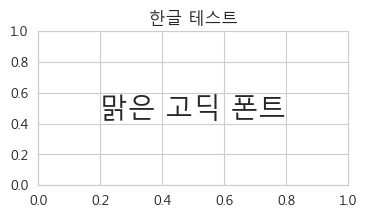

In [2]:
# 폰트 파일 경로 직접 지정
font_path = '/Users/yeong/Library/Fonts/malgun.ttf'

# 폰트 등록
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

# matplotlib에 적용
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = True

print(f"폰트 적용 완료: {font_name}")

plt.figure(figsize=(4, 2))
plt.title('한글 테스트')
plt.text(0.5, 0.5, '맑은 고딕 폰트', ha='center', va='center', fontsize=20)
plt.show()

## 1.2 GPU/MPS 디바이스 설정

In [3]:
import torch

# Device 설정 (Mac은 MPS, NVIDIA GPU는 CUDA, 없으면 CPU)
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f"사용 디바이스: {DEVICE}")

사용 디바이스: mps


In [4]:
# GPU/MPS 디바이스 감지 및 설정
import torch
import platform

def get_device():
    """
    사용 가능한 최적의 디바이스를 반환
    - CUDA (NVIDIA GPU)
    - MPS (Apple Silicon)
    - CPU (폴백)
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        device_name = torch.cuda.get_device_name(0)
        print(f"✅ CUDA GPU 사용 가능: {device_name}")
        print(f"   - CUDA 버전: {torch.version.cuda}")
        print(f"   - GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device('mps')
        print(f"✅ Apple MPS 사용 가능 (Metal Performance Shaders)")
        print(f"   - 시스템: {platform.processor()}")
    else:
        device = torch.device('cpu')
        print(f"⚠️ GPU 사용 불가, CPU 모드로 실행")
        print(f"   - CPU: {platform.processor()}")

    return device

# 디바이스 설정
DEVICE = get_device()
print(f"\n🖥️ 사용 디바이스: {DEVICE}")

# XGBoost GPU 설정을 위한 변수
USE_GPU = DEVICE.type in ['cuda', 'mps']
XGB_TREE_METHOD = 'gpu_hist' if DEVICE.type == 'cuda' else 'hist'

✅ Apple MPS 사용 가능 (Metal Performance Shaders)
   - 시스템: arm

🖥️ 사용 디바이스: mps


## 1.3 머신러닝 라이브러리 Import

In [5]:
# 머신러닝 라이브러리 (GPU 가속 지원)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix, roc_curve, precision_recall_curve)

# SMOTE for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
    print("✅ SMOTE 라이브러리 로드 완료!")
except ImportError:
    SMOTE_AVAILABLE = False
    print("⚠️ imbalanced-learn이 설치되지 않았습니다.")
    print("   설치: pip install imbalanced-learn")

# XGBoost (GPU 지원)
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost 라이브러리 로드 완료!")
    if DEVICE.type == 'cuda':
        print("   - XGBoost GPU 가속 활성화 (CUDA)")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost가 설치되지 않았습니다.")
    print("   설치: pip install xgboost")

# PyTorch 신경망 (GPU/MPS 지원)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("\n✅ 머신러닝 라이브러리 로드 완료!")

✅ SMOTE 라이브러리 로드 완료!
✅ XGBoost 라이브러리 로드 완료!

✅ 머신러닝 라이브러리 로드 완료!


---

# PART 2: 데이터 전처리

## 2.1 데이터 로드

In [6]:
# 데이터 로드
df = pd.read_csv('./data/2020/heart_2020_cleaned.csv')

print("✅ 데이터 로드 완료!")
print(f"📊 데이터 크기: {df.shape[0]:,}행 × {df.shape[1]}열")

✅ 데이터 로드 완료!
📊 데이터 크기: 319,795행 × 18열


## 2.2 데이터 기본 탐색

In [7]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [9]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


## 2.3 변수 인코딩

분석을 위해 범주형 변수를 수치형으로 변환합니다.

In [ ]:
# 데이터 복사본 생성
df_encoded = df.copy()

# 이진 변수 인코딩 (Yes=1, No=0)
binary_vars = ['Stroke', 'Smoking', 'PhysicalActivity', 'AlcoholDrinking',
               'HeartDisease', 'DiffWalking', 'Asthma', 'KidneyDisease', 'SkinCancer']

for var in binary_vars:
    if var in df_encoded.columns:
        df_encoded[var] = df_encoded[var].map({'Yes': 1, 'No': 0})

# Diabetic 변수 처리 (Yes, No, Yes (during pregnancy), No, borderline 등)
if 'Diabetic' in df_encoded.columns:
    df_encoded['Diabetic'] = df_encoded['Diabetic'].apply(
        lambda x: 1 if 'Yes' in str(x) else 0
    )

# 성별 인코딩 (Male=1, Female=0)
df_encoded['Sex'] = df_encoded['Sex'].map({'Male': 1, 'Female': 0})

# 나이 범주를 수치형으로 변환 (중앙값 사용)
age_mapping = {
    '18-24': 21, '25-29': 27, '30-34': 32, '35-39': 37,
    '40-44': 42, '45-49': 47, '50-54': 52, '55-59': 57,
    '60-64': 62, '65-69': 67, '70-74': 72, '75-79': 77,
    '80 or older': 82
}
df_encoded['Age_numeric'] = df_encoded['AgeCategory'].map(age_mapping)

# 일반건강상태 인코딩
health_mapping = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Very good': 4, 'Excellent': 5}
if 'GenHealth' in df_encoded.columns:
    df_encoded['GenHealth_numeric'] = df_encoded['GenHealth'].map(health_mapping)

print("✅ 변수 인코딩 완료!")
print(f"\n인코딩된 데이터 shape: {df_encoded.shape}")

✅ 변수 인코딩 완료!

인코딩된 데이터 shape: (319795, 20)


In [12]:
# 인코딩 결과 확인
print("인코딩 후 주요 변수 확인:")
df_encoded[['Stroke', 'Smoking', 'Sex', 'PhysicalActivity', 'Age_numeric', 'BMI']].head(10)

인코딩 후 주요 변수 확인:


,Stroke,Smoking,Sex,PhysicalActivity,Age_numeric,BMI
0,0,1,0,1,57,16.60
1,1,0,0,1,82,20.34
2,0,1,1,1,67,26.58
3,0,0,0,0,77,24.21
4,0,0,0,1,42,23.71
5,0,1,0,0,77,28.87
6,0,0,0,1,72,21.63
7,0,1,0,0,82,31.64
8,0,0,0,0,82,26.45
9,0,0,1,1,67,40.69


---

# PART 3: 탐색적 데이터 분석 (EDA) 및 시각화

## 3.0 데이터셋 개요 대시보드

데이터셋의 규모와 변수 유형을 한눈에 파악합니다.

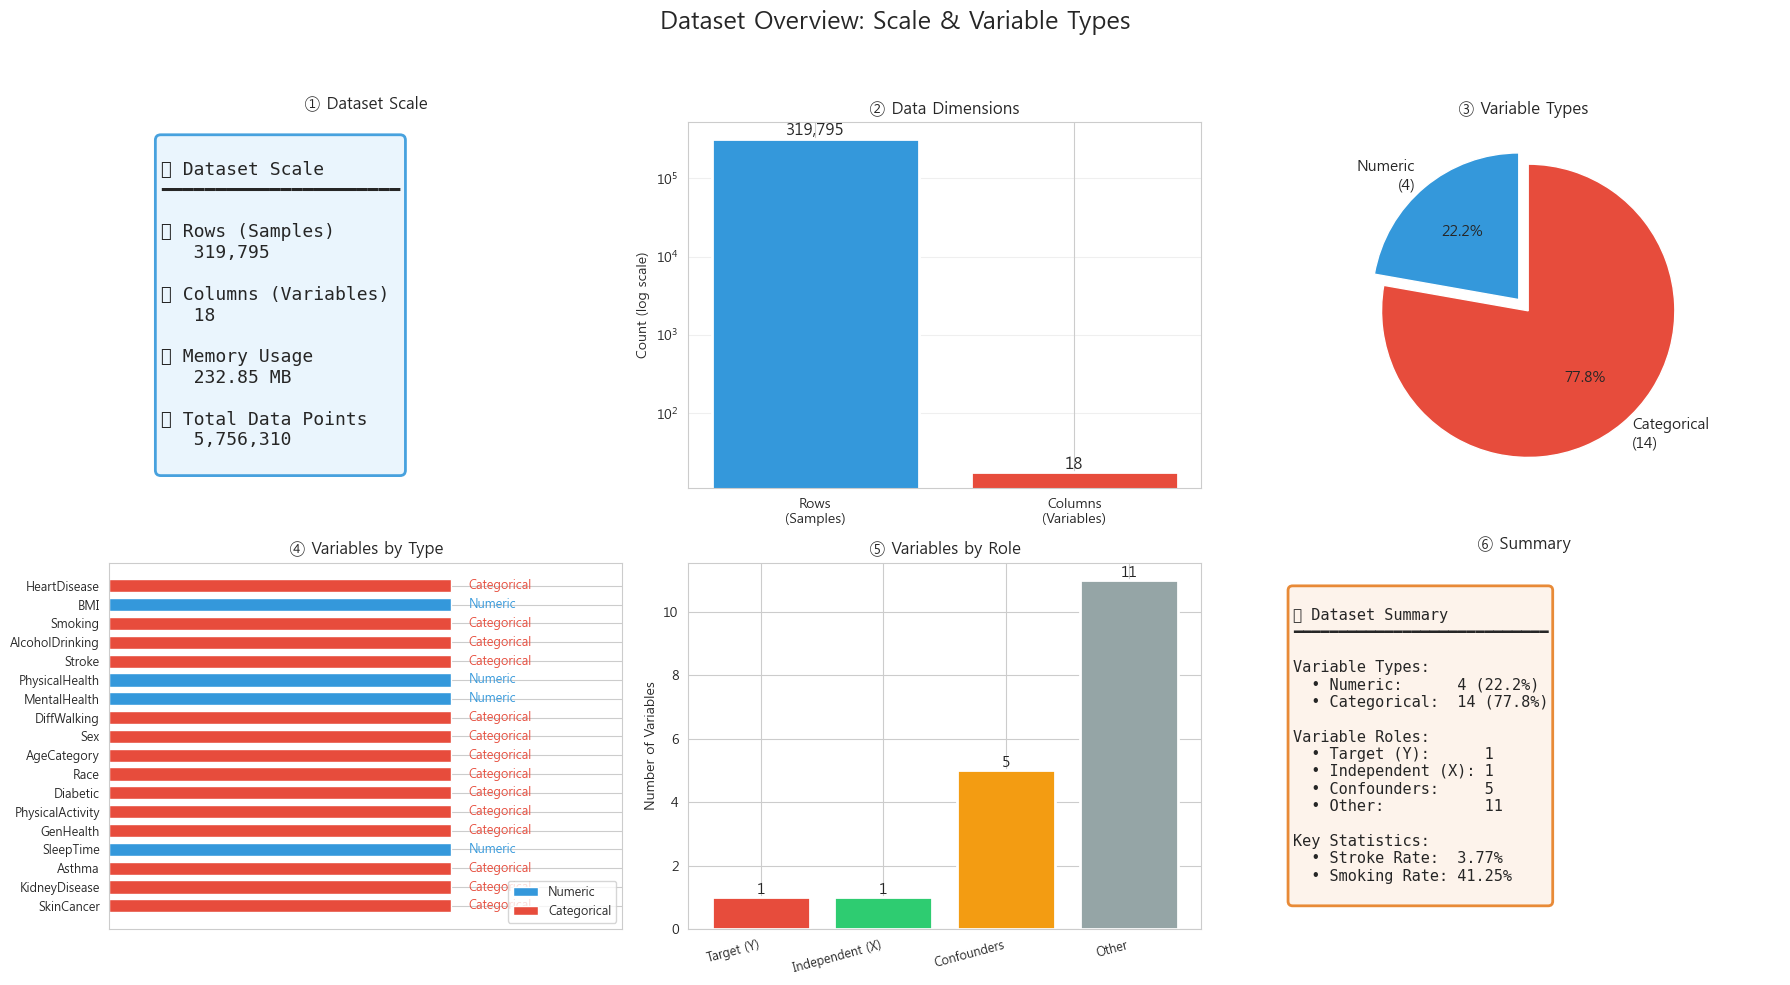


📊 데이터셋 개요: 319,795행 × 18열 (수치형 4, 범주형 14)


In [13]:
# ============================================================================
# 📊 데이터셋 개요 대시보드: 규모 및 변수 유형
# ============================================================================

fig = plt.figure(figsize=(18, 10))
fig.suptitle('Dataset Overview: Scale & Variable Types', 
             fontsize=18, fontweight='bold', y=0.98)

# --- 1. 데이터셋 규모 (왼쪽 상단) ---
ax1 = fig.add_subplot(2, 3, 1)
ax1.axis('off')

n_rows, n_cols = df.shape
memory_mb = df.memory_usage(deep=True).sum() / (1024 * 1024)

scale_text = f"""
📊 Dataset Scale
━━━━━━━━━━━━━━━━━━━━━━

📋 Rows (Samples)
   {n_rows:,}

📊 Columns (Variables)
   {n_cols}

💾 Memory Usage
   {memory_mb:.2f} MB

📈 Total Data Points
   {n_rows * n_cols:,}
"""
ax1.text(0.1, 0.5, scale_text, fontsize=13, family='monospace',
         verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='#E8F4FD', alpha=0.9, edgecolor='#3498db', linewidth=2))
ax1.set_title('① Dataset Scale', fontsize=12, fontweight='bold', pad=10)

# --- 2. 데이터 규모 시각화 (중앙 상단) ---
ax2 = fig.add_subplot(2, 3, 2)
categories = ['Rows\n(Samples)', 'Columns\n(Variables)']
values = [n_rows, n_cols]
colors = ['#3498db', '#e74c3c']
bars = ax2.bar(categories, values, color=colors, edgecolor='white', linewidth=2)
ax2.set_yscale('log')
ax2.set_ylabel('Count (log scale)', fontsize=10)
ax2.set_title('② Data Dimensions', fontsize=12, fontweight='bold')
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
             f'{val:,}', ha='center', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# --- 3. 변수 유형 분포 (오른쪽 상단) ---
ax3 = fig.add_subplot(2, 3, 3)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
n_numeric = len(numeric_cols)
n_categorical = len(categorical_cols)
sizes = [n_numeric, n_categorical]
labels = [f'Numeric\n({n_numeric})', f'Categorical\n({n_categorical})']
colors_pie = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors_pie, 
                                    autopct='%1.1f%%', explode=(0.05, 0.05),
                                    startangle=90, textprops={'fontsize': 11})
ax3.set_title('③ Variable Types', fontsize=12, fontweight='bold')

# --- 4. 변수별 유형 상세 (왼쪽 하단) ---
ax4 = fig.add_subplot(2, 3, 4)
var_names = df.columns.tolist()
var_types = ['Numeric' if col in numeric_cols else 'Categorical' for col in var_names]
var_colors = ['#3498db' if t == 'Numeric' else '#e74c3c' for t in var_types]
y_pos = range(len(var_names))
bars = ax4.barh(y_pos, [1]*len(var_names), color=var_colors, edgecolor='white', height=0.7)
ax4.set_yticks(y_pos)
ax4.set_yticklabels(var_names, fontsize=9)
ax4.set_xlim(0, 1.5)
ax4.set_xticks([])
ax4.set_title('④ Variables by Type', fontsize=12, fontweight='bold')
ax4.invert_yaxis()
for i, (name, vtype) in enumerate(zip(var_names, var_types)):
    ax4.text(1.05, i, vtype, va='center', fontsize=9, 
             color='#3498db' if vtype == 'Numeric' else '#e74c3c', fontweight='bold')
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='Numeric'),
                   Patch(facecolor='#e74c3c', label='Categorical')]
ax4.legend(handles=legend_elements, loc='lower right', fontsize=9)

# --- 5. 변수 역할 분류 (중앙 하단) ---
ax5 = fig.add_subplot(2, 3, 5)
roles = {
    'Target (Y)': ['Stroke'],
    'Independent (X)': ['Smoking'],
    'Confounders': ['AgeCategory', 'Sex', 'BMI', 'PhysicalActivity', 'AlcoholDrinking'],
    'Other': [col for col in df.columns if col not in ['Stroke', 'Smoking', 'AgeCategory', 'Sex', 'BMI', 'PhysicalActivity', 'AlcoholDrinking']]
}
role_counts = {k: len(v) for k, v in roles.items()}
role_names = list(role_counts.keys())
role_values = list(role_counts.values())
role_colors = ['#e74c3c', '#2ecc71', '#f39c12', '#95a5a6']
bars = ax5.bar(role_names, role_values, color=role_colors, edgecolor='white', linewidth=2)
ax5.set_ylabel('Number of Variables', fontsize=10)
ax5.set_title('⑤ Variables by Role', fontsize=12, fontweight='bold')
for bar, val in zip(bars, role_values):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(val), ha='center', fontsize=11, fontweight='bold')
ax5.set_xticklabels(role_names, fontsize=9, rotation=15, ha='right')

# --- 6. 데이터셋 요약 정보 (오른쪽 하단) ---
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""
📋 Dataset Summary
━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Variable Types:
  • Numeric:      {n_numeric} ({n_numeric/n_cols*100:.1f}%)
  • Categorical:  {n_categorical} ({n_categorical/n_cols*100:.1f}%)

Variable Roles:
  • Target (Y):      {role_counts['Target (Y)']}
  • Independent (X): {role_counts['Independent (X)']}
  • Confounders:     {role_counts['Confounders']}
  • Other:           {role_counts['Other']}

Key Statistics:
  • Stroke Rate:  {(df['Stroke']=='Yes').mean()*100:.2f}%
  • Smoking Rate: {(df['Smoking']=='Yes').mean()*100:.2f}%
"""
ax6.text(0.05, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='#FDF2E9', alpha=0.9, edgecolor='#e67e22', linewidth=2))
ax6.set_title('⑥ Summary', fontsize=12, fontweight='bold', pad=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('dataset_overview_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 데이터셋 개요: {n_rows:,}행 × {n_cols}열 (수치형 {n_numeric}, 범주형 {n_categorical})")

## 3.1 데이터 품질 대시보드

결측치와 이상치를 **한 눈에** 파악할 수 있는 통합 시각화입니다.

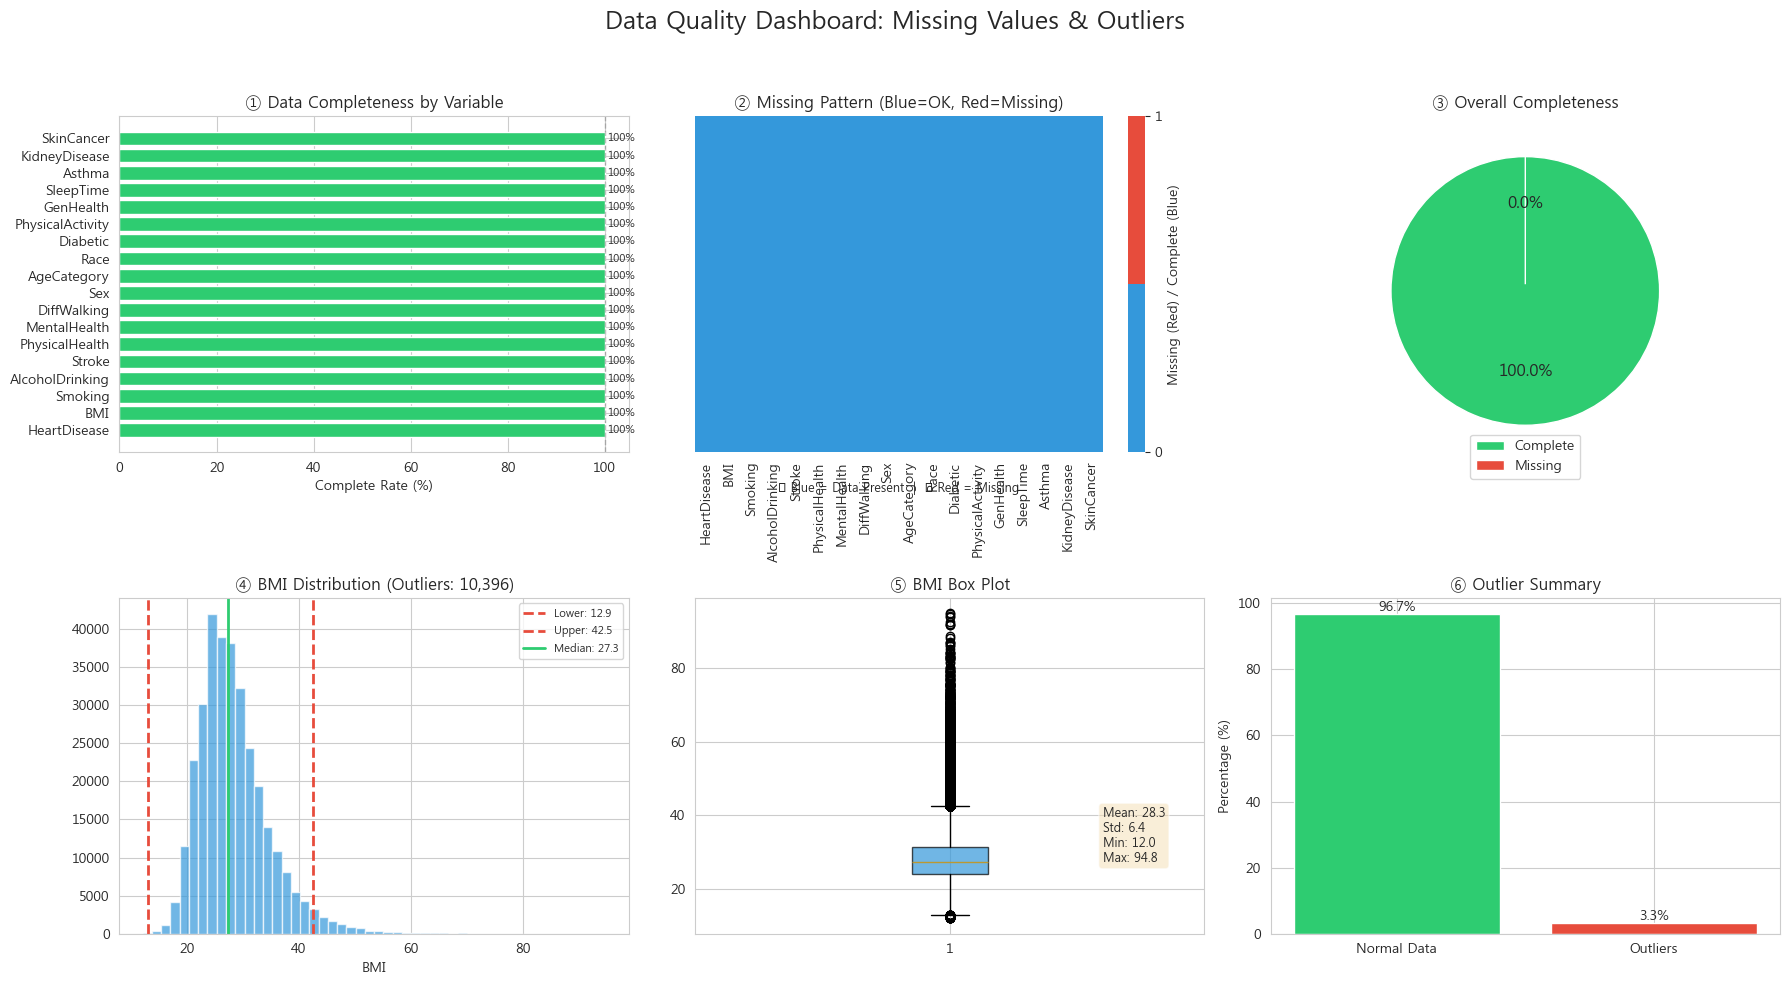


📊 데이터 품질 요약: 총 319,795행, 결측치 0개, BMI 이상치 10,396개 (3.3%)


In [10]:
# ============================================================================
# 📊 데이터 품질 대시보드: 결측치 & 이상치 한눈에 보기
# ============================================================================

fig = plt.figure(figsize=(18, 10))
fig.suptitle('Data Quality Dashboard: Missing Values & Outliers', 
             fontsize=18, fontweight='bold', y=0.98)

# 결측치 계산
missing_count = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
complete_pct = 100 - missing_pct  # 완성도 계산

# --- 1. 변수별 완성도 (Complete Rate) ---
ax1 = fig.add_subplot(2, 3, 1)
colors = ['#2ecc71' if pct == 100 else '#e74c3c' for pct in complete_pct]
bars = ax1.barh(complete_pct.index, complete_pct, color=colors, edgecolor='white')
ax1.set_xlabel('Complete Rate (%)', fontsize=10)
ax1.set_xlim(0, 105)
ax1.axvline(x=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_title('① Data Completeness by Variable', fontsize=12, fontweight='bold')

# 완성도 값 표시
for bar, pct in zip(bars, complete_pct):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{pct:.0f}%', va='center', fontsize=8, fontweight='bold')

# --- 2. 결측치 히트맵 (파란색=정상, 빨간색=결측) ---
ax2 = fig.add_subplot(2, 3, 2)
sample_size = min(1000, len(df))
df_sample = df.sample(sample_size, random_state=42)

# 커스텀 컬러맵: 파란색(0, 정상) → 빨간색(1, 결측)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#3498db', '#e74c3c'])  # 파란색(정상), 빨간색(결측)

sns.heatmap(df_sample.isnull().astype(int), cbar=True, yticklabels=False, 
            cmap=custom_cmap, ax=ax2, vmin=0, vmax=1,
            cbar_kws={'label': 'Missing (Red) / Complete (Blue)', 'ticks': [0, 1]})
ax2.set_title('② Missing Pattern (Blue=OK, Red=Missing)', fontsize=12, fontweight='bold')
ax2.set_xlabel('')

# 범례 설명 추가
ax2.text(0.5, -0.12, '🔵 Blue = Data Present  |  🔴 Red = Missing', 
         transform=ax2.transAxes, ha='center', fontsize=9, style='italic')

# --- 3. 데이터 완성도 (오른쪽 상단) ---
ax3 = fig.add_subplot(2, 3, 3)
overall_complete = 100 - missing_pct.mean()
sizes = [overall_complete, 100 - overall_complete]
colors_pie = ['#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax3.pie(sizes, colors=colors_pie, autopct='%1.1f%%', 
                                    startangle=90, textprops={'fontsize': 12}, 
                                    explode=(0.05, 0))
ax3.set_title(f'③ Overall Completeness', fontsize=12, fontweight='bold')

# 범례 추가
ax3.legend(wedges, ['Complete', 'Missing'], loc='lower center', 
           bbox_to_anchor=(0.5, -0.1), fontsize=10)

# --- 4. BMI 분포 및 이상치 (왼쪽 하단) ---
ax4 = fig.add_subplot(2, 3, 4)
Q1, Q3 = df['BMI'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['BMI'] < lower_bound) | (df['BMI'] > upper_bound)]

ax4.hist(df['BMI'], bins=50, color='#3498db', edgecolor='white', alpha=0.7)
ax4.axvline(lower_bound, color='#e74c3c', linestyle='--', linewidth=2, label=f'Lower: {lower_bound:.1f}')
ax4.axvline(upper_bound, color='#e74c3c', linestyle='--', linewidth=2, label=f'Upper: {upper_bound:.1f}')
ax4.axvline(df['BMI'].median(), color='#2ecc71', linestyle='-', linewidth=2, label=f'Median: {df["BMI"].median():.1f}')
ax4.set_xlabel('BMI')
ax4.set_title(f'④ BMI Distribution (Outliers: {len(outliers):,})', fontsize=12, fontweight='bold')
ax4.legend(fontsize=8)

# --- 5. BMI 박스플롯 (중앙 하단) ---
ax5 = fig.add_subplot(2, 3, 5)
bp = ax5.boxplot(df['BMI'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][0].set_alpha(0.7)
ax5.set_title('⑤ BMI Box Plot', fontsize=12, fontweight='bold')
stats_text = f"Mean: {df['BMI'].mean():.1f}\nStd: {df['BMI'].std():.1f}\nMin: {df['BMI'].min():.1f}\nMax: {df['BMI'].max():.1f}"
ax5.text(1.3, df['BMI'].median(), stats_text, fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# --- 6. 이상치 요약 (오른쪽 하단) ---
ax6 = fig.add_subplot(2, 3, 6)
outlier_pct = len(outliers) / len(df) * 100
categories = ['Normal Data', 'Outliers']
values = [100 - outlier_pct, outlier_pct]
bars = ax6.bar(categories, values, color=['#2ecc71', '#e74c3c'], edgecolor='white')
ax6.set_ylabel('Percentage (%)')
ax6.set_title('⑥ Outlier Summary', fontsize=12, fontweight='bold')
for bar, val in zip(bars, values):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('data_quality_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n📊 데이터 품질 요약: 총 {len(df):,}행, 결측치 {df.isnull().sum().sum()}개, BMI 이상치 {len(outliers):,}개 ({outlier_pct:.1f}%)")

## 3.2 변수 분포 대시보드

종속변수, 독립변수, 교란변수의 분포를 **한 눈에** 확인합니다.

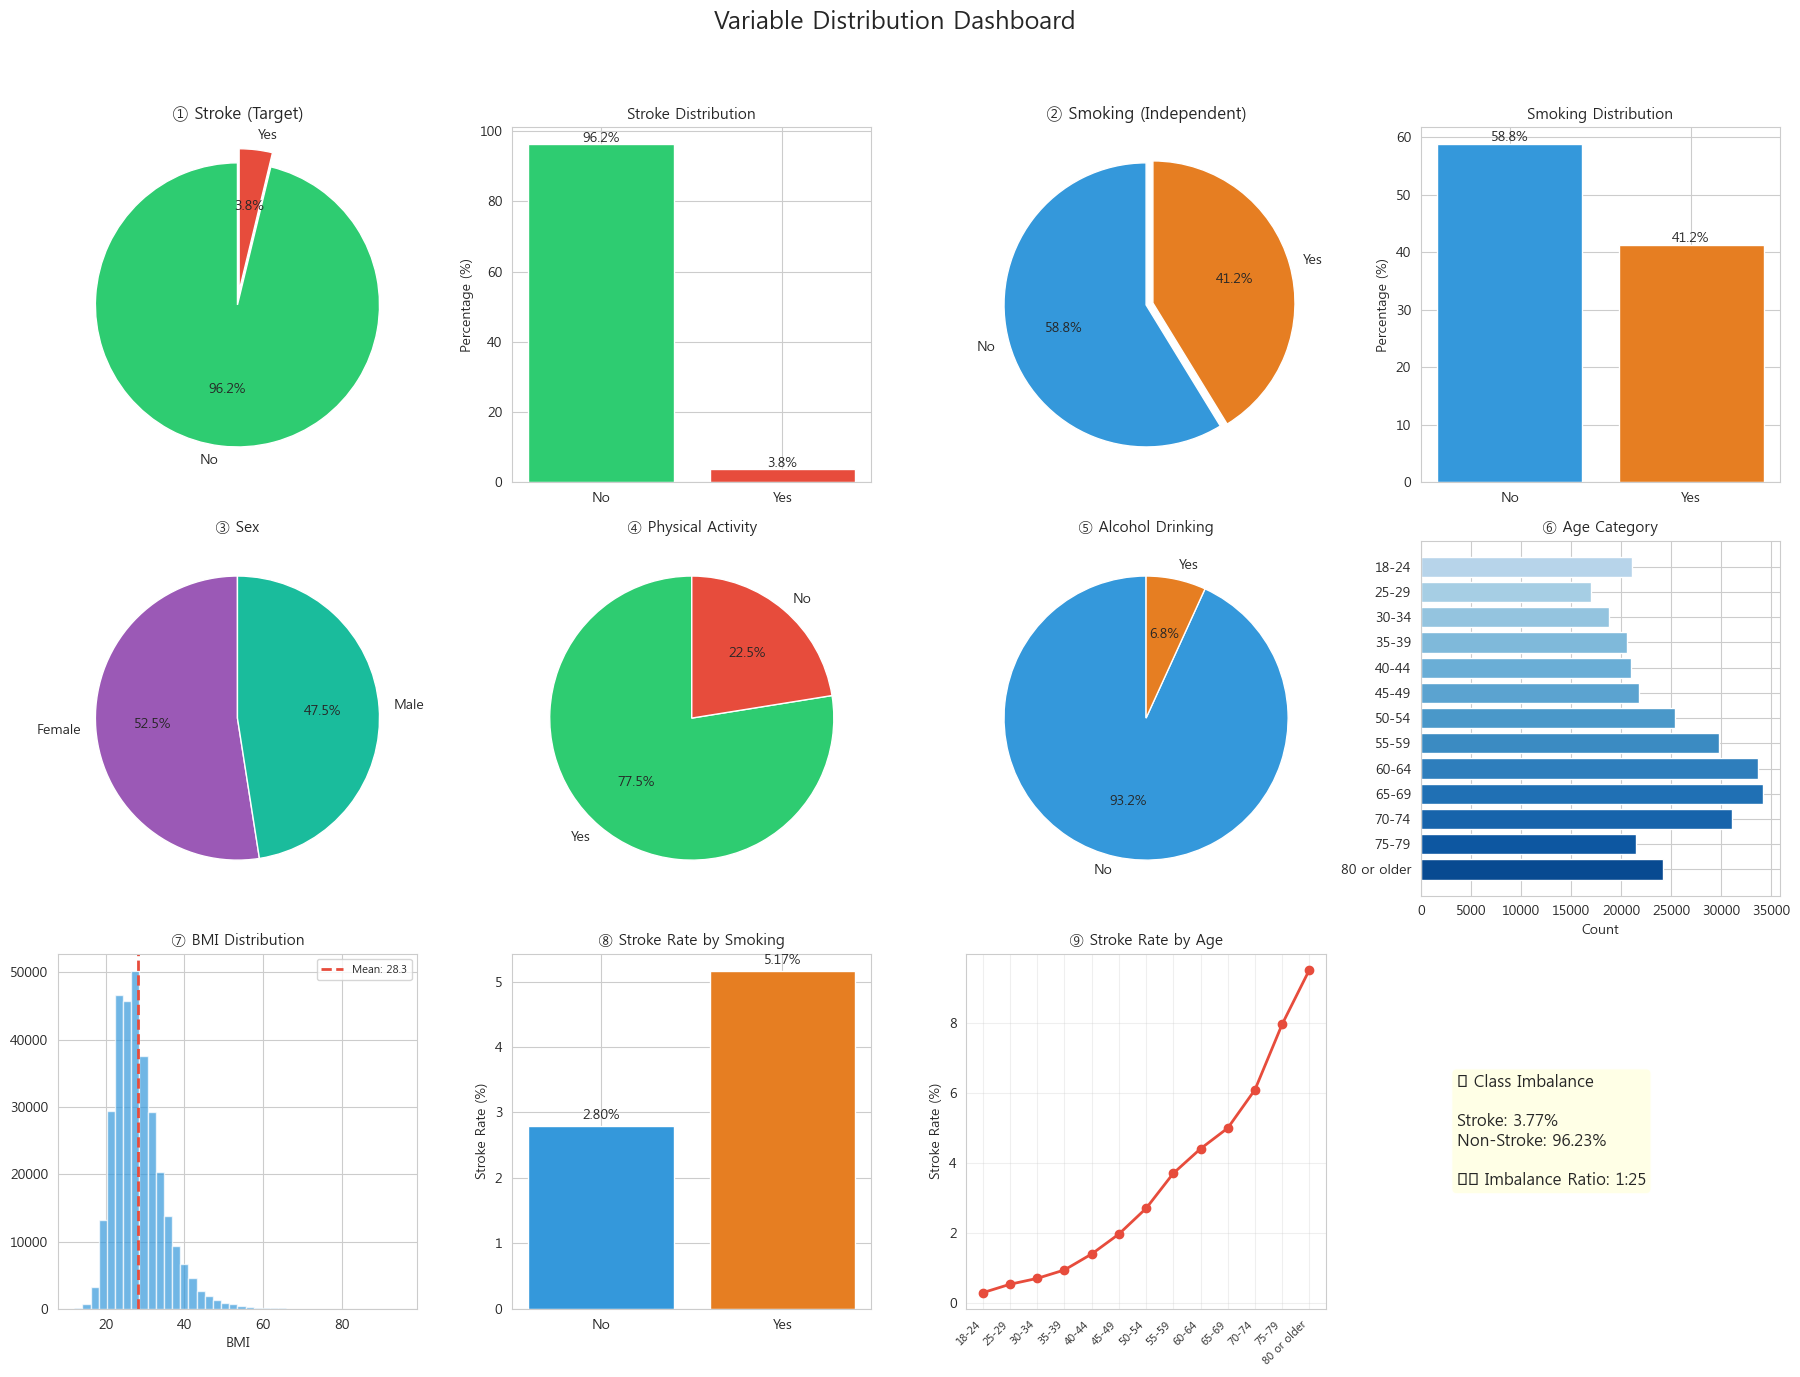

In [14]:
# ============================================================================
# 📊 변수 분포 대시보드: 종속/독립/교란 변수 한눈에 보기
# ============================================================================

fig = plt.figure(figsize=(18, 14))
fig.suptitle('Variable Distribution Dashboard', fontsize=18, fontweight='bold', y=0.98)

colors_stroke = {'No': '#2ecc71', 'Yes': '#e74c3c'}
colors_smoking = {'No': '#3498db', 'Yes': '#e67e22'}

# --- Row 1: 핵심 변수 ---
ax1 = fig.add_subplot(3, 4, 1)
stroke_counts = df['Stroke'].value_counts()
ax1.pie(stroke_counts, labels=stroke_counts.index, autopct='%1.1f%%',
        colors=[colors_stroke['No'], colors_stroke['Yes']], explode=(0, 0.1), startangle=90)
ax1.set_title('① Stroke (Target)', fontsize=12, fontweight='bold')

ax2 = fig.add_subplot(3, 4, 2)
stroke_pct = df['Stroke'].value_counts(normalize=True) * 100
bars = ax2.bar(stroke_pct.index, stroke_pct.values, color=[colors_stroke[x] for x in stroke_pct.index])
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Stroke Distribution', fontsize=11)
for bar, val in zip(bars, stroke_pct.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}%', ha='center', fontweight='bold')

ax3 = fig.add_subplot(3, 4, 3)
smoking_counts = df['Smoking'].value_counts()
ax3.pie(smoking_counts, labels=smoking_counts.index, autopct='%1.1f%%',
        colors=[colors_smoking['No'], colors_smoking['Yes']], explode=(0, 0.05), startangle=90)
ax3.set_title('② Smoking (Independent)', fontsize=12, fontweight='bold')

ax4 = fig.add_subplot(3, 4, 4)
smoking_pct = df['Smoking'].value_counts(normalize=True) * 100
bars = ax4.bar(smoking_pct.index, smoking_pct.values, color=[colors_smoking[x] for x in smoking_pct.index])
ax4.set_ylabel('Percentage (%)')
ax4.set_title('Smoking Distribution', fontsize=11)
for bar, val in zip(bars, smoking_pct.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}%', ha='center', fontweight='bold')

# --- Row 2: 교란변수 ---
ax5 = fig.add_subplot(3, 4, 5)
sex_counts = df['Sex'].value_counts()
ax5.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', colors=['#9b59b6', '#1abc9c'], startangle=90)
ax5.set_title('③ Sex', fontsize=11, fontweight='bold')

ax6 = fig.add_subplot(3, 4, 6)
pa_counts = df['PhysicalActivity'].value_counts()
ax6.pie(pa_counts, labels=pa_counts.index, autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
ax6.set_title('④ Physical Activity', fontsize=11, fontweight='bold')

ax7 = fig.add_subplot(3, 4, 7)
alcohol_counts = df['AlcoholDrinking'].value_counts()
ax7.pie(alcohol_counts, labels=alcohol_counts.index, autopct='%1.1f%%', colors=['#3498db', '#e67e22'], startangle=90)
ax7.set_title('⑤ Alcohol Drinking', fontsize=11, fontweight='bold')

ax8 = fig.add_subplot(3, 4, 8)
age_order = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']
age_counts = df['AgeCategory'].value_counts().reindex(age_order)
ax8.barh(age_counts.index, age_counts.values, color=plt.cm.Blues(np.linspace(0.3, 0.9, len(age_counts))))
ax8.set_xlabel('Count')
ax8.set_title('⑥ Age Category', fontsize=11, fontweight='bold')
ax8.invert_yaxis()

# --- Row 3: 연속형 & 핵심 분석 ---
ax9 = fig.add_subplot(3, 4, 9)
ax9.hist(df['BMI'], bins=40, color='#3498db', edgecolor='white', alpha=0.7)
ax9.axvline(df['BMI'].mean(), color='#e74c3c', linestyle='--', linewidth=2, label=f"Mean: {df['BMI'].mean():.1f}")
ax9.set_xlabel('BMI')
ax9.set_title('⑦ BMI Distribution', fontsize=11, fontweight='bold')
ax9.legend(fontsize=8)

ax10 = fig.add_subplot(3, 4, 10)
smoking_stroke = df.groupby('Smoking')['Stroke'].apply(lambda x: (x == 'Yes').mean() * 100)
bars = ax10.bar(smoking_stroke.index, smoking_stroke.values, color=['#3498db', '#e67e22'])
ax10.set_ylabel('Stroke Rate (%)')
ax10.set_title('⑧ Stroke Rate by Smoking', fontsize=11, fontweight='bold')
for bar, val in zip(bars, smoking_stroke.values):
    ax10.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}%', ha='center', fontweight='bold')

ax11 = fig.add_subplot(3, 4, 11)
age_stroke = df.groupby('AgeCategory')['Stroke'].apply(lambda x: (x == 'Yes').mean() * 100).reindex(age_order)
ax11.plot(range(len(age_stroke)), age_stroke.values, marker='o', color='#e74c3c', linewidth=2)
ax11.set_xticks(range(len(age_stroke)))
ax11.set_xticklabels(age_stroke.index, rotation=45, ha='right', fontsize=8)
ax11.set_ylabel('Stroke Rate (%)')
ax11.set_title('⑨ Stroke Rate by Age', fontsize=11, fontweight='bold')
ax11.grid(True, alpha=0.3)

ax12 = fig.add_subplot(3, 4, 12)
ax12.axis('off')
stroke_ratio = (df['Stroke'] == 'Yes').mean() * 100
imbalance_text = f"📊 Class Imbalance\n\nStroke: {stroke_ratio:.2f}%\nNon-Stroke: {100-stroke_ratio:.2f}%\n\n⚠️ Imbalance Ratio: 1:{int((100-stroke_ratio)/stroke_ratio)}"
ax12.text(0.1, 0.5, imbalance_text, fontsize=12, verticalalignment='center', 
          bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('variable_distribution_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 3.3 관계 분석 대시보드

변수 간의 관계를 교차표, 상관관계, 분포 비교를 통해 분석합니다.

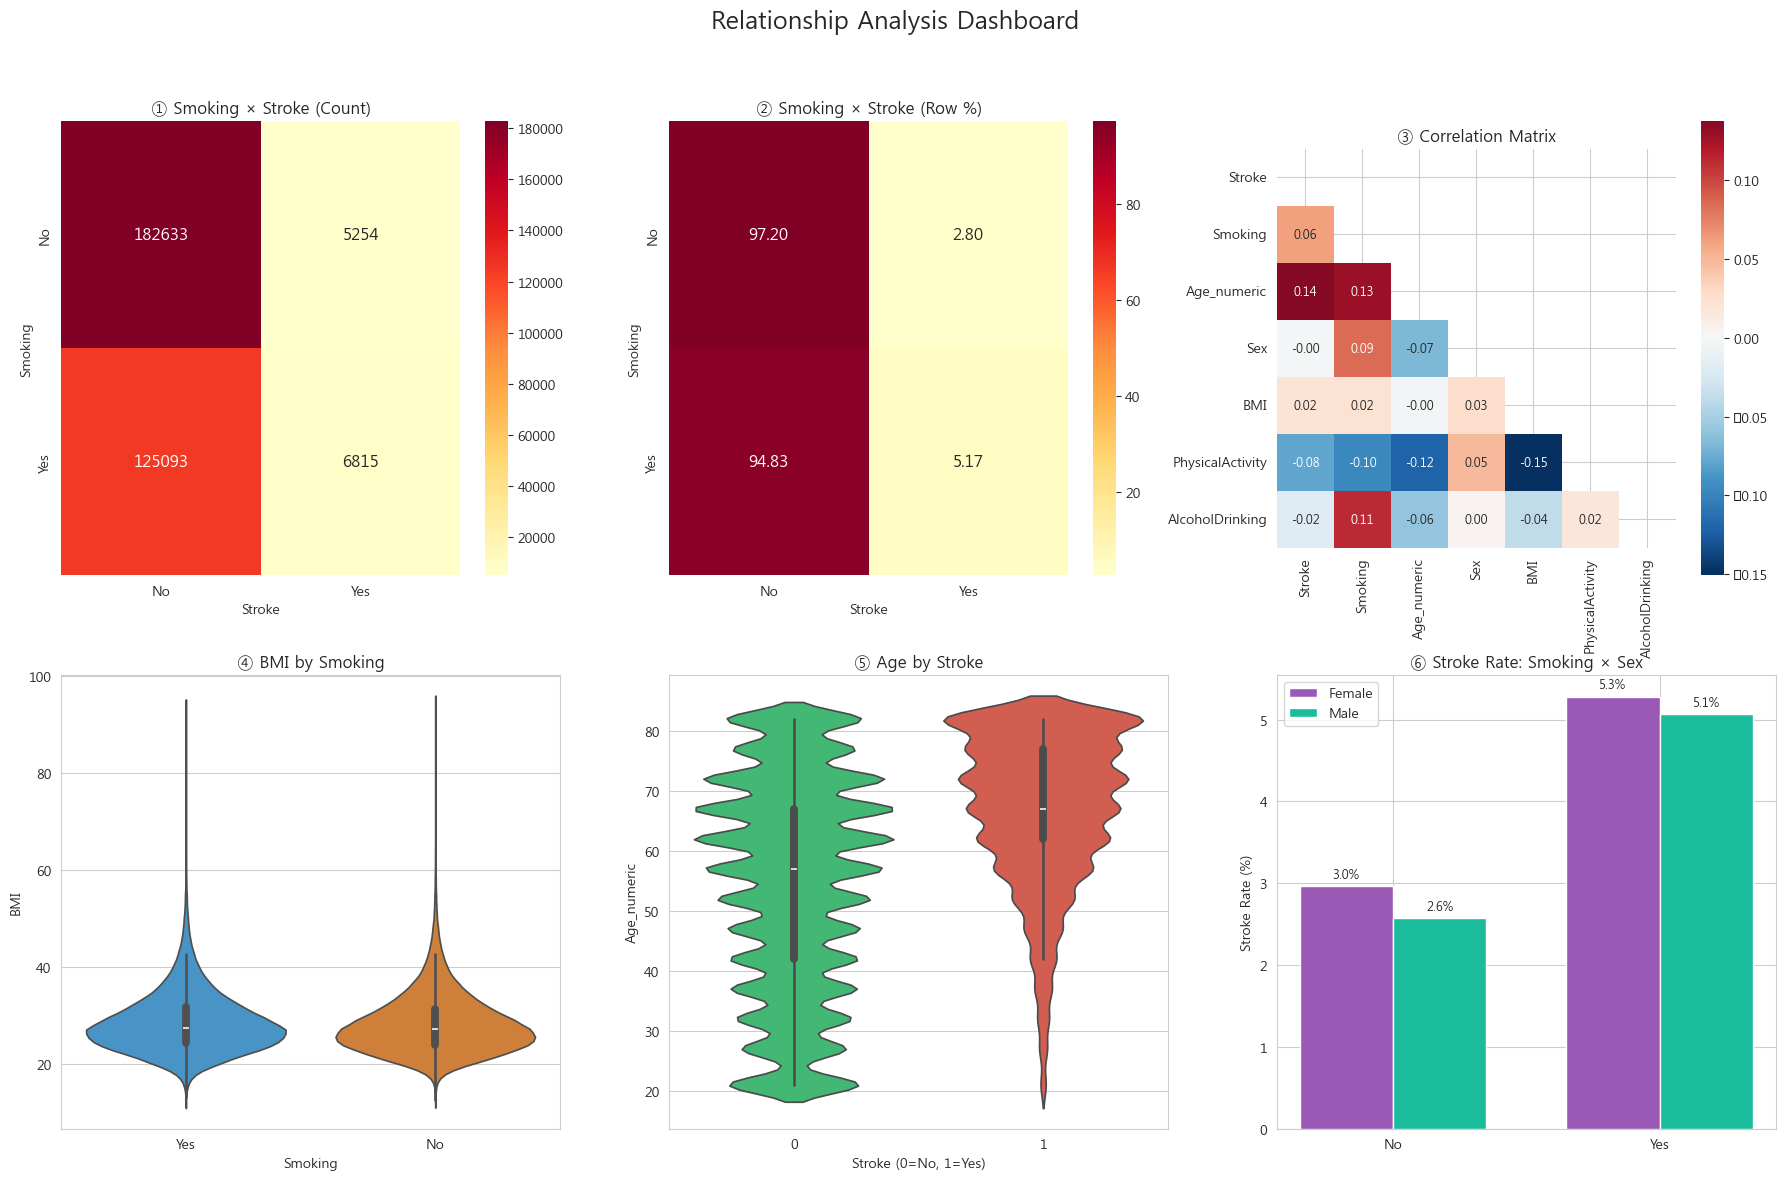

In [15]:
# ============================================================================
# 📊 관계 분석 대시보드: 변수 간 관계 한눈에 보기
# ============================================================================

fig = plt.figure(figsize=(18, 12))
fig.suptitle('Relationship Analysis Dashboard', fontsize=18, fontweight='bold', y=0.98)

# --- 1. 교차표 히트맵 ---
ax1 = fig.add_subplot(2, 3, 1)
crosstab = pd.crosstab(df['Smoking'], df['Stroke'])
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=ax1, annot_kws={'fontsize': 12})
ax1.set_title('① Smoking × Stroke (Count)', fontsize=12, fontweight='bold')

# --- 2. 교차표 비율 ---
ax2 = fig.add_subplot(2, 3, 2)
crosstab_pct = pd.crosstab(df['Smoking'], df['Stroke'], normalize='index') * 100
sns.heatmap(crosstab_pct, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax2, annot_kws={'fontsize': 12})
ax2.set_title('② Smoking × Stroke (Row %)', fontsize=12, fontweight='bold')

# --- 3. 상관관계 히트맵 ---
ax3 = fig.add_subplot(2, 3, 3)
numeric_cols = ['Stroke', 'Smoking', 'Age_numeric', 'Sex', 'BMI', 'PhysicalActivity', 'AlcoholDrinking']
corr_matrix = df_encoded[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax3, annot_kws={'fontsize': 9}, square=True)
ax3.set_title('③ Correlation Matrix', fontsize=12, fontweight='bold')

# --- 4. 흡연별 BMI 분포 ---
ax4 = fig.add_subplot(2, 3, 4)
sns.violinplot(data=df, x='Smoking', y='BMI', palette=['#3498db', '#e67e22'], ax=ax4)
ax4.set_title('④ BMI by Smoking', fontsize=12, fontweight='bold')

# --- 5. 뇌졸중별 나이 분포 ---
ax5 = fig.add_subplot(2, 3, 5)
sns.violinplot(data=df_encoded, x='Stroke', y='Age_numeric', palette=['#2ecc71', '#e74c3c'], ax=ax5)
ax5.set_title('⑤ Age by Stroke', fontsize=12, fontweight='bold')
ax5.set_xlabel('Stroke (0=No, 1=Yes)')

# --- 6. 흡연×성별 뇌졸중률 ---
ax6 = fig.add_subplot(2, 3, 6)
smoking_sex = df.groupby(['Smoking', 'Sex'])['Stroke'].apply(lambda x: (x == 'Yes').mean() * 100).unstack()
x = np.arange(len(smoking_sex.index))
width = 0.35
bars1 = ax6.bar(x - width/2, smoking_sex['Female'], width, label='Female', color='#9b59b6')
bars2 = ax6.bar(x + width/2, smoking_sex['Male'], width, label='Male', color='#1abc9c')
ax6.set_xticks(x)
ax6.set_xticklabels(smoking_sex.index)
ax6.set_ylabel('Stroke Rate (%)')
ax6.set_title('⑥ Stroke Rate: Smoking × Sex', fontsize=12, fontweight='bold')
ax6.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.1f}%', ha='center', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('relationship_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 3.4 층화 분석 대시보드

나이대별 트렌드, 4분류 분석, 층화 분석을 통해 심층적인 패턴을 파악합니다.

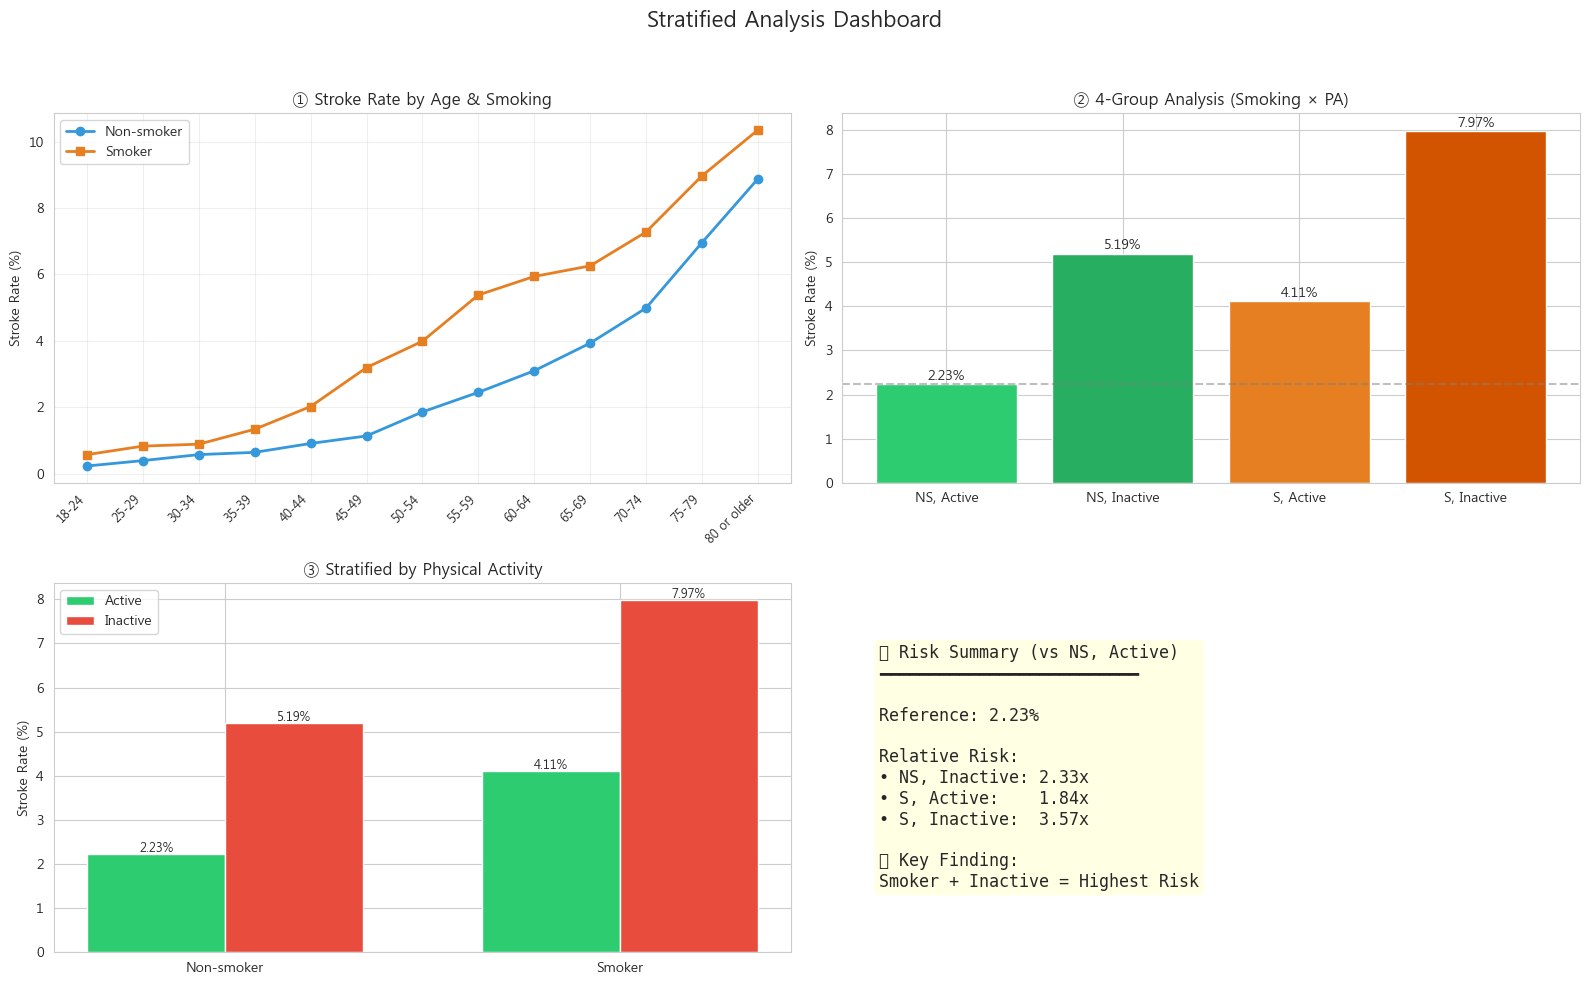

In [16]:
# ============================================================================
# 📊 층화 분석 대시보드: 4분류 분석 & 상호작용 효과
# ============================================================================

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Stratified Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)

age_order = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# --- 1. 나이대×흡연별 뇌졸중률 ---
ax1 = fig.add_subplot(2, 2, 1)
age_smoking = df.groupby(['AgeCategory', 'Smoking'])['Stroke'].apply(lambda x: (x == 'Yes').mean() * 100).unstack().reindex(age_order)
ax1.plot(range(len(age_order)), age_smoking['No'], marker='o', color='#3498db', linewidth=2, label='Non-smoker')
ax1.plot(range(len(age_order)), age_smoking['Yes'], marker='s', color='#e67e22', linewidth=2, label='Smoker')
ax1.set_xticks(range(len(age_order)))
ax1.set_xticklabels(age_order, rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Stroke Rate (%)')
ax1.set_title('① Stroke Rate by Age & Smoking', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- 2. 4분류 분석 ---
ax2 = fig.add_subplot(2, 2, 2)
df_temp = df.copy()
df_temp['Group'] = 'NS, Active'
df_temp.loc[(df_temp['Smoking'] == 'No') & (df_temp['PhysicalActivity'] == 'No'), 'Group'] = 'NS, Inactive'
df_temp.loc[(df_temp['Smoking'] == 'Yes') & (df_temp['PhysicalActivity'] == 'Yes'), 'Group'] = 'S, Active'
df_temp.loc[(df_temp['Smoking'] == 'Yes') & (df_temp['PhysicalActivity'] == 'No'), 'Group'] = 'S, Inactive'

group_order = ['NS, Active', 'NS, Inactive', 'S, Active', 'S, Inactive']
group_stroke = df_temp.groupby('Group')['Stroke'].apply(lambda x: (x == 'Yes').mean() * 100).reindex(group_order)
colors_group = ['#2ecc71', '#27ae60', '#e67e22', '#d35400']
bars = ax2.bar(range(len(group_stroke)), group_stroke.values, color=colors_group)
ax2.set_xticks(range(len(group_stroke)))
ax2.set_xticklabels(group_order, fontsize=10)
ax2.set_ylabel('Stroke Rate (%)')
ax2.set_title('② 4-Group Analysis (Smoking × PA)', fontsize=12, fontweight='bold')
for bar, val in zip(bars, group_stroke.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}%', ha='center', fontweight='bold')
ax2.axhline(y=group_stroke['NS, Active'], color='gray', linestyle='--', alpha=0.5)

# --- 3. 신체활동별 층화 ---
ax3 = fig.add_subplot(2, 2, 3)
pa_yes = df[df['PhysicalActivity'] == 'Yes'].groupby('Smoking')['Stroke'].apply(lambda x: (x == 'Yes').mean() * 100)
pa_no = df[df['PhysicalActivity'] == 'No'].groupby('Smoking')['Stroke'].apply(lambda x: (x == 'Yes').mean() * 100)
x = np.arange(2)
width = 0.35
bars1 = ax3.bar(x - width/2, [pa_yes['No'], pa_yes['Yes']], width, label='Active', color='#2ecc71')
bars2 = ax3.bar(x + width/2, [pa_no['No'], pa_no['Yes']], width, label='Inactive', color='#e74c3c')
ax3.set_xticks(x)
ax3.set_xticklabels(['Non-smoker', 'Smoker'])
ax3.set_ylabel('Stroke Rate (%)')
ax3.set_title('③ Stratified by Physical Activity', fontsize=12, fontweight='bold')
ax3.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{bar.get_height():.2f}%', ha='center', fontsize=9)

# --- 4. 위험도 요약 ---
ax4 = fig.add_subplot(2, 2, 4)
ax4.axis('off')
base = group_stroke['NS, Active']
rr = group_stroke / base
summary = f"""📊 Risk Summary (vs NS, Active)
━━━━━━━━━━━━━━━━━━━━━━━━━━

Reference: {base:.2f}%

Relative Risk:
• NS, Inactive: {rr['NS, Inactive']:.2f}x
• S, Active:    {rr['S, Active']:.2f}x  
• S, Inactive:  {rr['S, Inactive']:.2f}x

🔍 Key Finding:
Smoker + Inactive = Highest Risk"""
ax4.text(0.05, 0.5, summary, fontsize=12, family='monospace', verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('stratified_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---

# PART 4: 통계 분석

## 4.1 카이제곱 검정: 흡연 vs 뇌졸중

In [17]:
# 교차표 생성
contingency_table = pd.crosstab(df['Smoking'], df['Stroke'])
print("교차표:")
print(contingency_table)

# 카이제곱 검정 실행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\n카이제곱 검정 결과:")
print(f"  - 카이제곱 통계량 (χ²): {chi2:.4f}")
print(f"  - 자유도 (df): {dof}")
print(f"  - p-value: {p_value:.4e}")

# 기대빈도 확인
print(f"\n기대빈도:")
print(pd.DataFrame(expected,
                   index=contingency_table.index,
                   columns=contingency_table.columns).round(2))

교차표:
Stroke       No   Yes
Smoking              
No       182633  5254
Yes      125093  6815

카이제곱 검정 결과:
  - 카이제곱 통계량 (χ²): 1198.1399
  - 자유도 (df): 1
  - p-value: 1.5472e-262

기대빈도:
Stroke          No      Yes
Smoking                    
No       180796.18  7090.82
Yes      126929.82  4978.18


In [18]:
# 결과 해석
alpha = 0.05
if p_value < alpha:
    print(f"✅ 결론: p-value ({p_value:.4e}) < α ({alpha})")
    print("   → 귀무가설 기각: 흡연과 뇌졸중 사이에 유의한 연관성이 있습니다.")
else:
    print(f"❌ 결론: p-value ({p_value:.4e}) >= α ({alpha})")
    print("   → 귀무가설 채택: 흡연과 뇌졸중 사이에 유의한 연관성이 없습니다.")

✅ 결론: p-value (1.5472e-262) < α (0.05)
   → 귀무가설 기각: 흡연과 뇌졸중 사이에 유의한 연관성이 있습니다.


## 4.2 효과 크기 (Cramér's V)

In [19]:
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"효과 크기 (Cramér's V): {cramers_v:.4f}")
if cramers_v < 0.1:
    print("   → 해석: 약한 연관성")
elif cramers_v < 0.3:
    print("   → 해석: 중간 정도의 연관성")
else:
    print("   → 해석: 강한 연관성")

효과 크기 (Cramér's V): 0.0612
   → 해석: 약한 연관성


## 4.3 다변량 로지스틱 회귀분석

### 분석용 데이터 준비

In [20]:
# 필요한 변수만 선택
analysis_vars = ['Stroke', 'Smoking', 'Age_numeric', 'Sex', 'BMI',
                 'PhysicalActivity', 'AlcoholDrinking']
df_analysis = df_encoded[analysis_vars].dropna()

print(f"분석 대상 샘플 수: {len(df_analysis):,}명")
print(f"결측치로 제외된 샘플: {len(df_encoded) - len(df_analysis):,}명")

분석 대상 샘플 수: 319,795명
결측치로 제외된 샘플: 0명


### Model 1: 비보정 모델 (Crude)

In [21]:
# 로지스틱 회귀 모델 적합
X1 = sm.add_constant(df_analysis['Smoking'])
y = df_analysis['Stroke']

model1 = sm.Logit(y, X1).fit(disp=0)

print("="*50)
print(model1.summary())
print("="*50)

                           Logit Regression Results                           
Dep. Variable:                 Stroke   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319793
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Jan 2026   Pseudo R-squ.:                 0.01144
Time:                        23:59:55   Log-Likelihood:                -50801.
converged:                       True   LL-Null:                       -51389.
Covariance Type:            nonrobust   LLR p-value:                1.256e-257
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5485      0.014   -253.589      0.000      -3.576      -3.521
Smoking        0.6386      0.019     34.106      0.000       0.602       0.675


In [22]:
# 오즈비 계산
or_model1 = np.exp(model1.params['Smoking'])
ci_model1 = np.exp(model1.conf_int().loc['Smoking'])

print(f"흡연의 비보정 오즈비 (Crude OR):")
print(f"  - OR = {or_model1:.4f}")
print(f"  - 95% CI: [{ci_model1[0]:.4f}, {ci_model1[1]:.4f}]")
print(f"  - p-value = {model1.pvalues['Smoking']:.4e}")

흡연의 비보정 오즈비 (Crude OR):
  - OR = 1.8937
  - 95% CI: [1.8255, 1.9645]
  - p-value = 5.9609e-255


### Model 2: 인구학적 변수 보정

In [23]:
X2 = sm.add_constant(df_analysis[['Smoking', 'Age_numeric', 'Sex']])
model2 = sm.Logit(y, X2).fit(disp=0)

print("="*50)
print(model2.summary())
print("="*50)

                           Logit Regression Results                           
Dep. Variable:                 Stroke   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319791
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Jan 2026   Pseudo R-squ.:                 0.07348
Time:                        23:59:55   Log-Likelihood:                -47613.
converged:                       True   LL-Null:                       -51389.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -6.5006      0.049   -133.541      0.000      -6.596      -6.405
Smoking         0.4958      0.019     25.993      0.000       0.458       0.533
Age_numeric     0.0493      0.001     71.331    

In [24]:
# 오즈비 계산
or_model2 = np.exp(model2.params['Smoking'])
ci_model2 = np.exp(model2.conf_int().loc['Smoking'])

print(f"흡연의 보정 오즈비 (나이, 성별 보정):")
print(f"  - Adjusted OR = {or_model2:.4f}")
print(f"  - 95% CI: [{ci_model2[0]:.4f}, {ci_model2[1]:.4f}]")
print(f"  - p-value = {model2.pvalues['Smoking']:.4e}")

흡연의 보정 오즈비 (나이, 성별 보정):
  - Adjusted OR = 1.6417
  - 95% CI: [1.5815, 1.7043]
  - p-value = 5.9486e-149


### Model 3: 모든 교란변수 보정 (Full Model)

In [25]:
X3 = sm.add_constant(df_analysis[['Smoking', 'Age_numeric', 'Sex', 'BMI',
                                   'PhysicalActivity', 'AlcoholDrinking']])
model3 = sm.Logit(y, X3).fit(disp=0)

print("="*50)
print(model3.summary())
print("="*50)

                           Logit Regression Results                           
Dep. Variable:                 Stroke   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319788
Method:                           MLE   Df Model:                            6
Date:                Mon, 19 Jan 2026   Pseudo R-squ.:                 0.08429
Time:                        23:59:56   Log-Likelihood:                -47057.
converged:                       True   LL-Null:                       -51389.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.4963      0.074    -88.158      0.000      -6.641      -6.352
Smoking              0.4657      0.019     24.172      0.000       0.428       0.503
Age_numeric          0.0480 

In [26]:
# 모든 변수의 오즈비 계산
print("모든 변수의 오즈비 (Full Model):")
print("-"*60)

or_full = np.exp(model3.params)
ci_full = np.exp(model3.conf_int())
pvalues = model3.pvalues

or_table = pd.DataFrame({
    'Odds Ratio': or_full,
    '95% CI Lower': ci_full[0],
    '95% CI Upper': ci_full[1],
    'p-value': pvalues
})
print(or_table.round(4))

모든 변수의 오즈비 (Full Model):
------------------------------------------------------------
                  Odds Ratio  95% CI Lower  95% CI Upper  p-value
const                 0.0015        0.0013        0.0017   0.0000
Smoking               1.5931        1.5341        1.6544   0.0000
Age_numeric           1.0492        1.0477        1.0506   0.0000
Sex                   1.0411        1.0028        1.0808   0.0351
BMI                   1.0172        1.0142        1.0201   0.0000
PhysicalActivity      0.5702        0.5483        0.5929   0.0000
AlcoholDrinking       0.7038        0.6427        0.7706   0.0000


### 모델 비교 (오즈비 변화)

In [27]:
comparison_data = {
    'Model': ['Model 1 (Crude)', 'Model 2 (Age, Sex)', 'Model 3 (Full)'],
    'Odds Ratio': [or_model1, or_model2, np.exp(model3.params['Smoking'])],
    '95% CI': [
        f"[{ci_model1[0]:.3f}, {ci_model1[1]:.3f}]",
        f"[{ci_model2[0]:.3f}, {ci_model2[1]:.3f}]",
        f"[{np.exp(model3.conf_int().loc['Smoking'][0]):.3f}, {np.exp(model3.conf_int().loc['Smoking'][1]):.3f}]"
    ],
    'p-value': [
        f"{model1.pvalues['Smoking']:.4e}",
        f"{model2.pvalues['Smoking']:.4e}",
        f"{model3.pvalues['Smoking']:.4e}"
    ]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

             Model  Odds Ratio         95% CI     p-value
   Model 1 (Crude)    1.893747 [1.826, 1.965] 5.9609e-255
Model 2 (Age, Sex)    1.641747 [1.582, 1.704] 5.9486e-149
    Model 3 (Full)    1.593135 [1.534, 1.654] 4.3384e-129


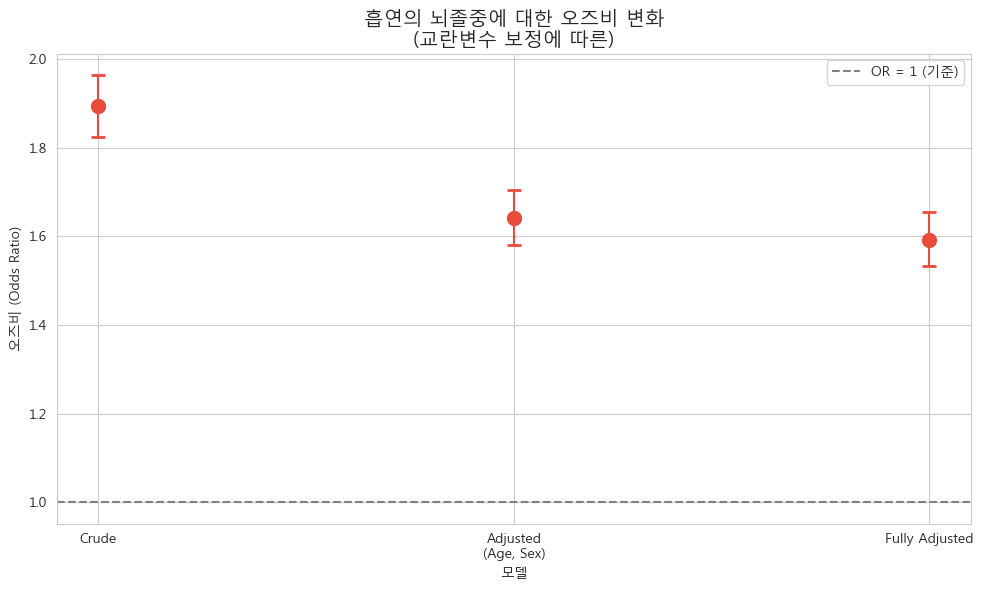

In [28]:
# 시각화: 오즈비 비교
plt.figure(figsize=(10, 6))
models = ['Crude', 'Adjusted\n(Age, Sex)', 'Fully Adjusted']
ors = [or_model1, or_model2, np.exp(model3.params['Smoking'])]
ci_lowers = [ci_model1[0], ci_model2[0], np.exp(model3.conf_int().loc['Smoking'][0])]
ci_uppers = [ci_model1[1], ci_model2[1], np.exp(model3.conf_int().loc['Smoking'][1])]

plt.errorbar(models, ors,
             yerr=[np.array(ors) - np.array(ci_lowers),
                   np.array(ci_uppers) - np.array(ors)],
             fmt='o', markersize=10, capsize=5, capthick=2, color='#e74c3c')
plt.axhline(y=1, color='gray', linestyle='--', label='OR = 1 (기준)')
plt.xlabel('모델')
plt.ylabel('오즈비 (Odds Ratio)')
plt.title('흡연의 뇌졸중에 대한 오즈비 변화\n(교란변수 보정에 따른)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

## 4.4 상호작용 효과 분석

In [29]:
# 상호작용 항 생성
df_analysis['Smoking_x_PhysActivity'] = df_analysis['Smoking'] * df_analysis['PhysicalActivity']

# 상호작용 모델
X_interaction = sm.add_constant(df_analysis[['Smoking', 'Age_numeric', 'Sex', 'BMI',
                                              'PhysicalActivity', 'AlcoholDrinking',
                                              'Smoking_x_PhysActivity']])
model_interaction = sm.Logit(y, X_interaction).fit(disp=0)

print("="*50)
print(model_interaction.summary())
print("="*50)

                           Logit Regression Results                           
Dep. Variable:                 Stroke   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319787
Method:                           MLE   Df Model:                            7
Date:                Mon, 19 Jan 2026   Pseudo R-squ.:                 0.08432
Time:                        23:59:56   Log-Likelihood:                -47056.
converged:                       True   LL-Null:                       -51389.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6.4651      0.076    -85.185      0.000      -6.614      -6.316
Smoking                    0.4237      0.031     13.518      0.000       0.362       0.485
Age_

In [30]:
# 상호작용 항의 유의성
interaction_pvalue = model_interaction.pvalues['Smoking_x_PhysActivity']
interaction_or = np.exp(model_interaction.params['Smoking_x_PhysActivity'])

print(f"상호작용 항 (Smoking × PhysicalActivity) 결과:")
print(f"  - 계수: {model_interaction.params['Smoking_x_PhysActivity']:.4f}")
print(f"  - OR: {interaction_or:.4f}")
print(f"  - p-value: {interaction_pvalue:.4e}")

if interaction_pvalue < 0.05:
    print("\n✅ 결론: 상호작용 효과가 통계적으로 유의합니다 (p < 0.05)")
    print("   → 흡연이 뇌졸중에 미치는 영향은 신체활동 여부에 따라 달라집니다.")
else:
    print("\n❌ 결론: 상호작용 효과가 통계적으로 유의하지 않습니다 (p >= 0.05)")
    print("   → 흡연이 뇌졸중에 미치는 영향은 신체활동 여부와 무관합니다.")

상호작용 항 (Smoking × PhysicalActivity) 결과:
  - 계수: 0.0667
  - OR: 1.0690
  - p-value: 9.0173e-02

❌ 결론: 상호작용 효과가 통계적으로 유의하지 않습니다 (p >= 0.05)
   → 흡연이 뇌졸중에 미치는 영향은 신체활동 여부와 무관합니다.


### 층화 분석: 신체활동 여부별

In [31]:
# 신체활동 있는 그룹
df_active = df_analysis[df_analysis['PhysicalActivity'] == 1]
X_active = sm.add_constant(df_active[['Smoking', 'Age_numeric', 'Sex', 'BMI', 'AlcoholDrinking']])
y_active = df_active['Stroke']
model_active = sm.Logit(y_active, X_active).fit(disp=0)

or_active = np.exp(model_active.params['Smoking'])
ci_active = np.exp(model_active.conf_int().loc['Smoking'])

# 신체활동 없는 그룹
df_inactive = df_analysis[df_analysis['PhysicalActivity'] == 0]
X_inactive = sm.add_constant(df_inactive[['Smoking', 'Age_numeric', 'Sex', 'BMI', 'AlcoholDrinking']])
y_inactive = df_inactive['Stroke']
model_inactive = sm.Logit(y_inactive, X_inactive).fit(disp=0)

or_inactive = np.exp(model_inactive.params['Smoking'])
ci_inactive = np.exp(model_inactive.conf_int().loc['Smoking'])

print("층화 분석 결과:")
print("-"*60)
print(f"\n신체활동 있는 그룹 (n = {len(df_active):,}):")
print(f"  - 흡연 OR = {or_active:.4f}")
print(f"  - 95% CI: [{ci_active[0]:.4f}, {ci_active[1]:.4f}]")
print(f"  - p-value = {model_active.pvalues['Smoking']:.4e}")

print(f"\n신체활동 없는 그룹 (n = {len(df_inactive):,}):")
print(f"  - 흡연 OR = {or_inactive:.4f}")
print(f"  - 95% CI: [{ci_inactive[0]:.4f}, {ci_inactive[1]:.4f}]")
print(f"  - p-value = {model_inactive.pvalues['Smoking']:.4e}")

층화 분석 결과:
------------------------------------------------------------

신체활동 있는 그룹 (n = 247,957):
  - 흡연 OR = 1.6190
  - 95% CI: [1.5436, 1.6980]
  - p-value = 2.7841e-87

신체활동 없는 그룹 (n = 71,838):
  - 흡연 OR = 1.5236
  - 95% CI: [1.4324, 1.6206]
  - p-value = 9.1119e-41


### 4분류 분석

In [32]:
# 4분류 변수 생성 (문자열 대신 숫자 라벨 사용)
df_analysis['group_code'] = 0  # Non-smoker, Active (참조 그룹)
df_analysis.loc[(df_analysis['Smoking'] == 0) & (df_analysis['PhysicalActivity'] == 0), 'group_code'] = 1  # Non-smoker, Inactive
df_analysis.loc[(df_analysis['Smoking'] == 1) & (df_analysis['PhysicalActivity'] == 1), 'group_code'] = 2  # Smoker, Active
df_analysis.loc[(df_analysis['Smoking'] == 1) & (df_analysis['PhysicalActivity'] == 0), 'group_code'] = 3  # Smoker, Inactive

# 그룹별 뇌졸중 발생률 확인
group_labels = {0: 'Non-smoker, Active', 1: 'Non-smoker, Inactive',
                2: 'Smoker, Active', 3: 'Smoker, Inactive'}

print("그룹별 뇌졸중 발생률:")
for code, label in group_labels.items():
    subset = df_analysis[df_analysis['group_code'] == code]
    stroke_rate = subset['Stroke'].mean() * 100
    print(f"  {label}: {len(subset):,}명, 발생률 {stroke_rate:.2f}%")

그룹별 뇌졸중 발생률:
  Non-smoker, Active: 152,065명, 발생률 2.23%
  Non-smoker, Inactive: 35,822명, 발생률 5.19%
  Smoker, Active: 95,892명, 발생률 4.11%
  Smoker, Inactive: 36,016명, 발생률 7.97%


In [33]:
# 더미 변수 수동 생성 (참조 그룹 = 0: Non-smoker, Active)
df_analysis['group_1'] = (df_analysis['group_code'] == 1).astype(int)  # Non-smoker, Inactive
df_analysis['group_2'] = (df_analysis['group_code'] == 2).astype(int)  # Smoker, Active
df_analysis['group_3'] = (df_analysis['group_code'] == 3).astype(int)  # Smoker, Inactive

# 로지스틱 회귀
X_group = sm.add_constant(df_analysis[['group_1', 'group_2', 'group_3',
                                        'Age_numeric', 'Sex', 'BMI', 'AlcoholDrinking']])
model_group = sm.Logit(df_analysis['Stroke'], X_group).fit(disp=0)

print("4분류 분석 결과 (참조: 비흡연 + 신체활동 있음):")
print("-"*60)

group_var_names = {
    'group_1': 'Non-smoker, Inactive',
    'group_2': 'Smoker, Active',
    'group_3': 'Smoker, Inactive'
}

for var, label in group_var_names.items():
    or_val = np.exp(model_group.params[var])
    ci_low = np.exp(model_group.conf_int().loc[var][0])
    ci_high = np.exp(model_group.conf_int().loc[var][1])
    pval = model_group.pvalues[var]

    print(f"\n{label}:")
    print(f"  OR = {or_val:.4f}, 95% CI = [{ci_low:.4f}, {ci_high:.4f}], p = {pval:.4e}")

4분류 분석 결과 (참조: 비흡연 + 신체활동 있음):
------------------------------------------------------------

Non-smoker, Inactive:
  OR = 1.8231, 95% CI = [1.7180, 1.9346], p = 1.8113e-87

Smoker, Active:
  OR = 1.6331, 95% CI = [1.5574, 1.7124], p = 2.1173e-91

Smoker, Inactive:
  OR = 2.7850, 95% CI = [2.6426, 2.9350], p = 0.0000e+00


## 4.5 모델 진단

### 다중공선성 (VIF)

In [34]:
# Full Model의 독립변수들로 VIF 계산
X_for_vif = df_analysis[['Smoking', 'Age_numeric', 'Sex', 'BMI',
                          'PhysicalActivity', 'AlcoholDrinking']].dropna()

vif_data = pd.DataFrame()
vif_data['변수'] = X_for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

print("분산팽창계수 (VIF):")
print(vif_data.round(4))

if vif_data['VIF'].max() < 5:
    print("\n✅ 다중공선성 문제 없음 (모든 VIF < 5)")
elif vif_data['VIF'].max() < 10:
    print("\n⚠️ 일부 변수에서 주의 필요 (VIF > 5)")
else:
    print("\n❌ 심각한 다중공선성 문제 (VIF > 10)")

분산팽창계수 (VIF):
                 변수     VIF
0           Smoking  1.7793
1       Age_numeric  7.6195
2               Sex  1.9030
3               BMI  8.9387
4  PhysicalActivity  3.6702
5   AlcoholDrinking  1.0867

⚠️ 일부 변수에서 주의 필요 (VIF > 5)


### 모델 적합도 및 ROC-AUC

In [35]:
# Pseudo R² (McFadden's R²)
print(f"Full Model (Model 3) 적합도:")
print(f"  - Log-Likelihood: {model3.llf:.4f}")
print(f"  - Pseudo R² (McFadden): {model3.prsquared:.4f}")
print(f"  - AIC: {model3.aic:.4f}")
print(f"  - BIC: {model3.bic:.4f}")

Full Model (Model 3) 적합도:
  - Log-Likelihood: -47057.2096
  - Pseudo R² (McFadden): 0.0843
  - AIC: 94128.4192
  - BIC: 94203.1473


In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

# 예측 확률
y_pred_prob = model3.predict(X3)

# ROC 곡선
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
auc_score = roc_auc_score(y, y_pred_prob)

print(f"ROC-AUC Score: {auc_score:.4f}")

ROC-AUC Score: 0.7412


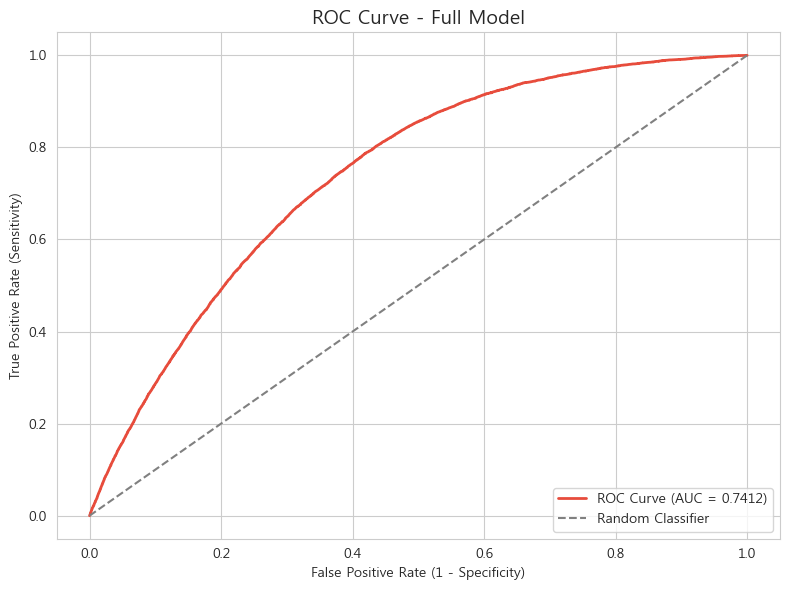

In [37]:
# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Full Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

---

# PART 5: 머신러닝

## 5.1 데이터 준비

In [38]:
# 머신러닝용 데이터 준비
# 기존 df_encoded 데이터에서 필요한 변수 선택
ml_features = ['Smoking', 'Age_numeric', 'Sex', 'BMI',
               'PhysicalActivity', 'AlcoholDrinking']

# 결측치 제거
df_ml = df_encoded[ml_features + ['Stroke']].dropna()

# 특성(X)과 타겟(y) 분리
X = df_ml[ml_features]
y = df_ml['Stroke']

print(f"전체 데이터 크기: {len(df_ml):,}")
print(f"특성 변수 수: {len(ml_features)}")
print(f"\n클래스 분포:")
print(f"  - 비뇌졸중 (0): {(y == 0).sum():,} ({(y == 0).mean()*100:.2f}%)")
print(f"  - 뇌졸중 (1): {(y == 1).sum():,} ({(y == 1).mean()*100:.2f}%)")

전체 데이터 크기: 319,795
특성 변수 수: 6

클래스 분포:
  - 비뇌졸중 (0): 307,726 (96.23%)
  - 뇌졸중 (1): 12,069 (3.77%)


In [39]:
# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"훈련 데이터: {len(X_train):,}")
print(f"테스트 데이터: {len(X_test):,}")

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ 데이터 분할 및 스케일링 완료!")

훈련 데이터: 255,836
테스트 데이터: 63,959

✅ 데이터 분할 및 스케일링 완료!


In [40]:
# SMOTE로 클래스 불균형 처리
if SMOTE_AVAILABLE:
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    print("SMOTE 적용 후 훈련 데이터:")
    print(f"  - 비뇌졸중 (0): {(y_train_resampled == 0).sum():,}")
    print(f"  - 뇌졸중 (1): {(y_train_resampled == 1).sum():,}")
else:
    X_train_resampled = X_train_scaled
    y_train_resampled = y_train
    print("⚠️ SMOTE 미적용 (라이브러리 없음)")

SMOTE 적용 후 훈련 데이터:
  - 비뇌졸중 (0): 246,181
  - 뇌졸중 (1): 246,181


## 5.2 sklearn 모델 학습

In [41]:
# 모델 정의 (학습 시간 단축 버전)
# 모델 정의 (학습 시간 단축 버전)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=1000,
        random_state=42,
        n_iter_no_change=10,
        validation_fraction=0.1,
        tol=1e-4
    ),
    'SVM': SVC(probability=True, random_state=42, max_iter=1000)
}

# XGBoost GPU 가속 설정 (XGBoost 3.1+ 버전 호환)
if XGBOOST_AVAILABLE:
    xgb_params = {
        'n_estimators': 1000,
        'random_state': 42,
        'eval_metric': 'logloss',
        'early_stopping_rounds': 10,
    }

    if DEVICE.type == 'cuda':
        xgb_params.update({
            'device': 'cuda',  # gpu_id 대신 device 사용
            'tree_method': 'hist',  # gpu_hist → hist (자동 감지)
        })
        models['XGBoost (GPU)'] = XGBClassifier(**xgb_params)
        print("🚀 XGBoost: CUDA GPU 가속 모드")
    else:
        xgb_params.update({
            'device': 'cpu',
            'tree_method': 'hist',
            'n_jobs': -1
        })
        models['XGBoost'] = XGBClassifier(**xgb_params)
        print("⚡ XGBoost: CPU 최적화 모드")


# 결과 저장용 딕셔너리
results = {}

print(f"\n🚀 모델 학습 시작... (디바이스: {DEVICE})\n")
print("="*70)

import time

for name, model in models.items():
    print(f"\n[{name}] 학습 중...")
    start_time = time.time()

    # XGBoost는 eval_set 필요 (early stopping용)
    if 'XGBoost' in name:
        model.fit(
            X_train_resampled, y_train_resampled,
            eval_set=[(X_test_scaled, y_test)],
            verbose=False
        )
        print(f"  📊 최적 반복 횟수: {model.best_iteration}")
    else:
        model.fit(X_train_resampled, y_train_resampled)

    # 예측
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    elapsed_time = time.time() - start_time

    # 성능 지표 계산
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'y_pred_proba': y_pred_proba,
        'train_time': elapsed_time
    }

    print(f"  ⏱️ 학습 시간: {elapsed_time:.2f}초")
    print(f"  - Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  - Precision: {results[name]['precision']:.4f}")
    print(f"  - Recall: {results[name]['recall']:.4f}")
    print(f"  - F1 Score: {results[name]['f1']:.4f}")
    print(f"  - ROC-AUC: {results[name]['roc_auc']:.4f}")

print("\n" + "="*70)
print("\n✅ 모든 모델 학습 완료!")

⚡ XGBoost: CPU 최적화 모드

🚀 모델 학습 시작... (디바이스: mps)


[Logistic Regression] 학습 중...
  ⏱️ 학습 시간: 0.06초
  - Accuracy: 0.6336
  - Precision: 0.0727
  - Recall: 0.7407
  - F1 Score: 0.1324
  - ROC-AUC: 0.7452

[Random Forest] 학습 중...
  ⏱️ 학습 시간: 38.84초
  - Accuracy: 0.8699
  - Precision: 0.0721
  - Recall: 0.2063
  - F1 Score: 0.1069
  - ROC-AUC: 0.6392

[Gradient Boosting] 학습 중...
  ⏱️ 학습 시간: 150.39초
  - Accuracy: 0.7331
  - Precision: 0.0806
  - Recall: 0.5833
  - F1 Score: 0.1416
  - ROC-AUC: 0.7320

[SVM] 학습 중...
  ⏱️ 학습 시간: 96.74초
  - Accuracy: 0.5132
  - Precision: 0.0412
  - Recall: 0.5336
  - F1 Score: 0.0764
  - ROC-AUC: 0.5000

[XGBoost] 학습 중...
  📊 최적 반복 횟수: 801
  ⏱️ 학습 시간: 2.37초
  - Accuracy: 0.7136
  - Precision: 0.0710
  - Recall: 0.5456
  - F1 Score: 0.1257
  - ROC-AUC: 0.6988


✅ 모든 모델 학습 완료!


## 5.3 모델 성능 비교

In [42]:
# 성능 지표 비교 DataFrame 생성
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1 Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results]
})

print("📊 모델 성능 비교표:")
print(metrics_df.round(4).to_string(index=False))

📊 모델 성능 비교표:
              Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
Logistic Regression    0.6336     0.0727  0.7407    0.1324   0.7452
      Random Forest    0.8699     0.0721  0.2063    0.1069   0.6392
  Gradient Boosting    0.7331     0.0806  0.5833    0.1416   0.7320
                SVM    0.5132     0.0412  0.5336    0.0764   0.5000
            XGBoost    0.7136     0.0710  0.5456    0.1257   0.6988


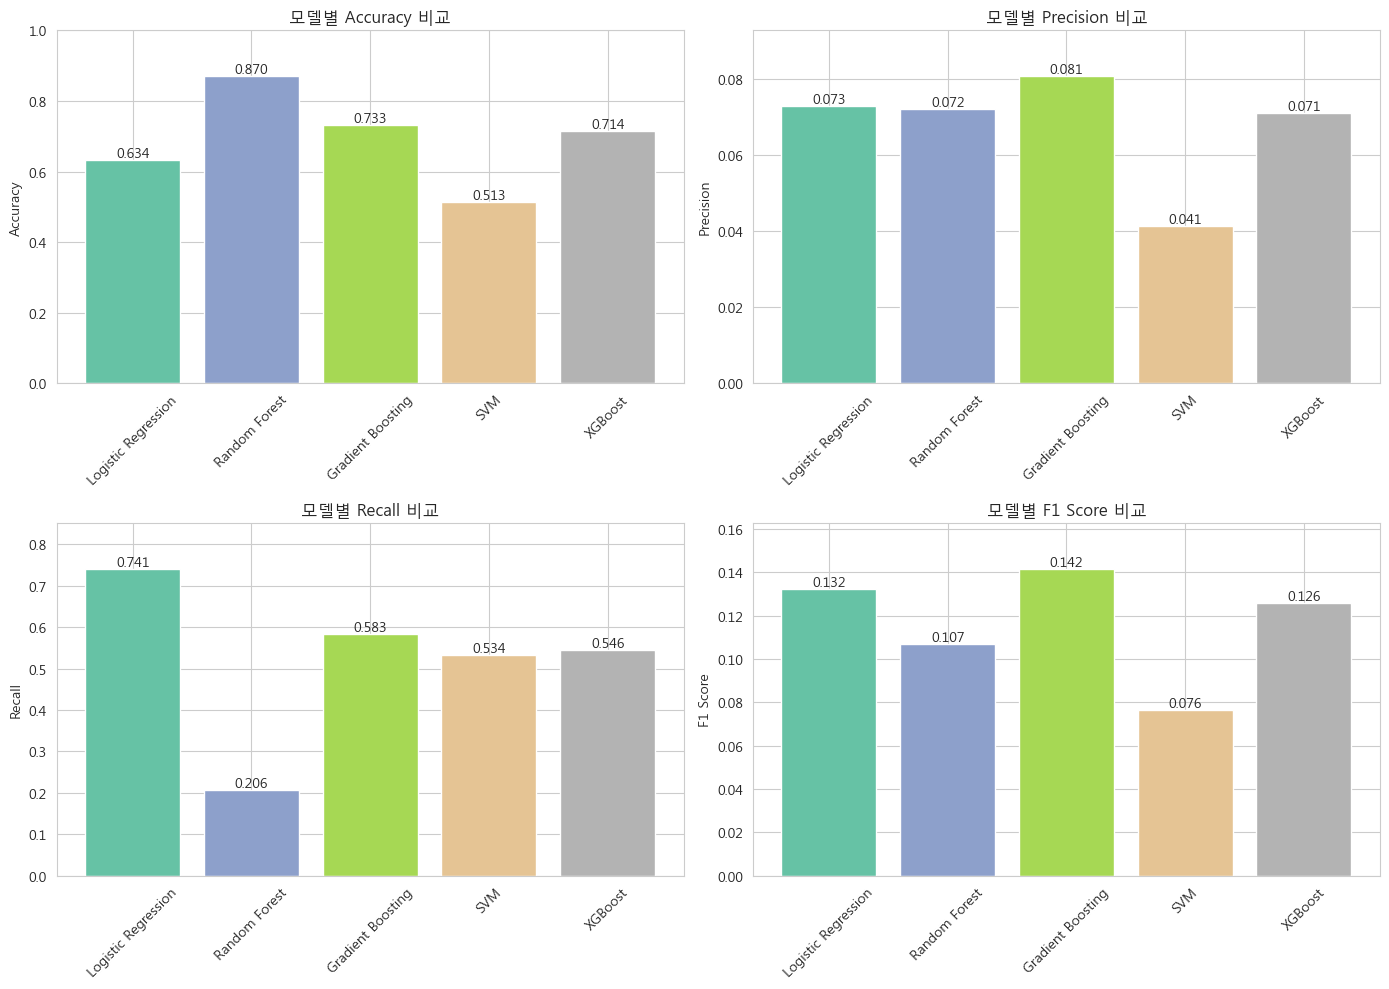

In [43]:
# 성능 지표 막대 그래프
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = plt.cm.Set2(np.linspace(0, 1, len(results)))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = metrics_df[metric].values
    bars = ax.bar(metrics_df['Model'], values, color=colors)
    ax.set_ylabel(metric)
    ax.set_title(f'모델별 {metric} 비교', fontweight='bold')
    ax.set_ylim(0, max(values) * 1.15)
    ax.tick_params(axis='x', rotation=45)

    # 막대 위에 값 표시
    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

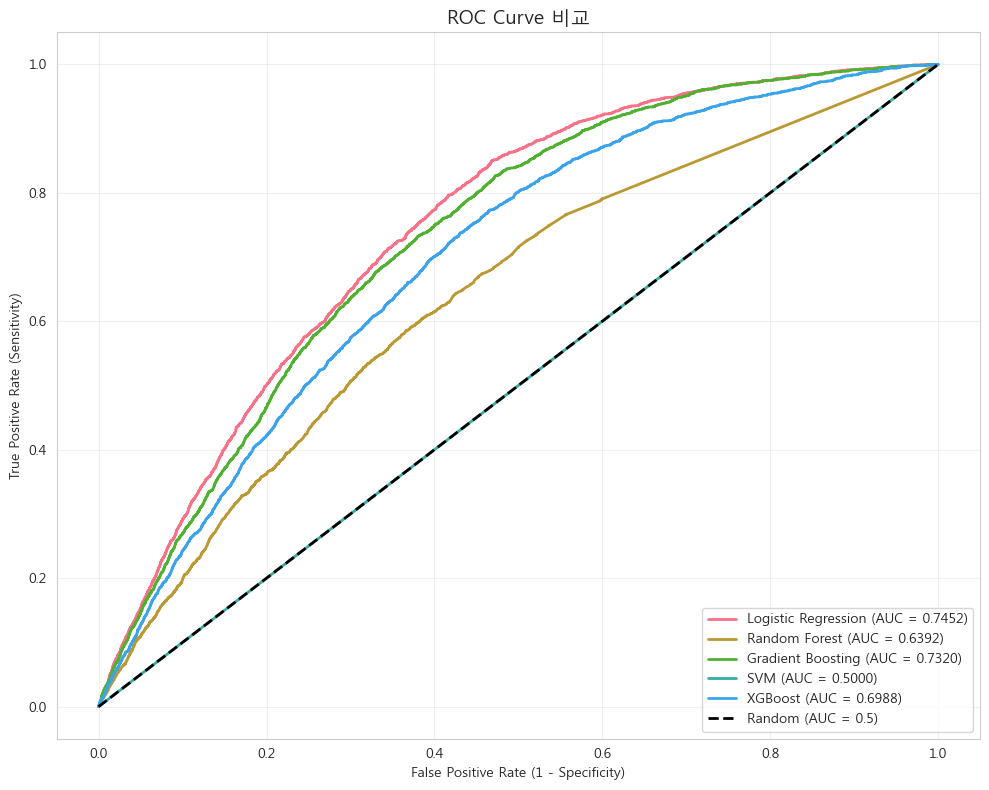

In [44]:
# ROC 곡선 비교
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {result['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve 비교', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

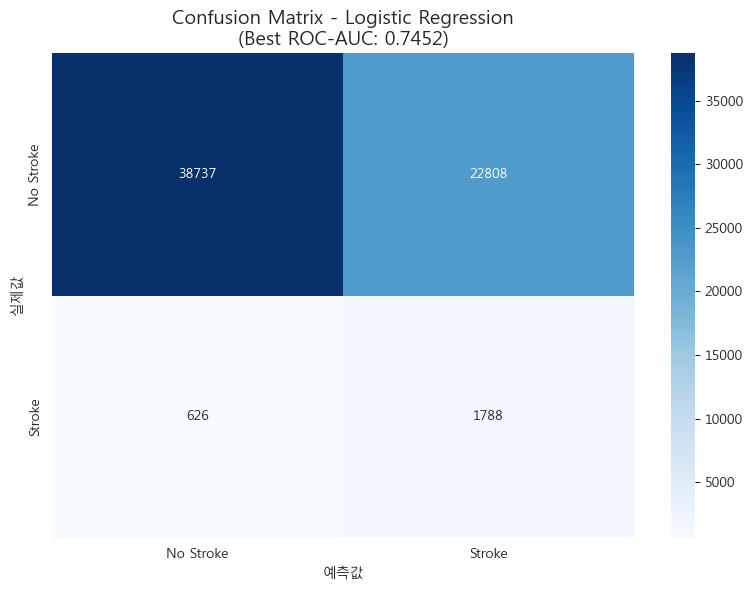


📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.98      0.63      0.77     61545
      Stroke       0.07      0.74      0.13      2414

    accuracy                           0.63     63959
   macro avg       0.53      0.69      0.45     63959
weighted avg       0.95      0.63      0.74     63959



In [45]:
# 최고 성능 모델의 Confusion Matrix
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title(f'Confusion Matrix - {best_model_name}\n(Best ROC-AUC: {results[best_model_name]["roc_auc"]:.4f})',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 {best_model_name} Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Stroke', 'Stroke']))

## 5.4 PyTorch 신경망

In [46]:
# PyTorch 신경망 정의
class StrokeNN(nn.Module):
    def __init__(self, input_dim):
        super(StrokeNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

# 데이터를 PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train_resampled).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train_resampled.values if hasattr(y_train_resampled, 'values') else y_train_resampled).to(DEVICE)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test.values).to(DEVICE)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# 모델 초기화
input_dim = X_train_tensor.shape[1]
nn_model = StrokeNN(input_dim).to(DEVICE)

# 손실 함수 및 옵티마이저
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"🧠 PyTorch 신경망 모델 생성 완료!")
print(f"   - 디바이스: {DEVICE}")
print(f"   - 입력 차원: {input_dim}")
print(f"   - 파라미터 수: {sum(p.numel() for p in nn_model.parameters()):,}")

🧠 PyTorch 신경망 모델 생성 완료!
   - 디바이스: mps
   - 입력 차원: 6
   - 파라미터 수: 3,265


In [47]:
# PyTorch 신경망 학습
print(f"🚀 PyTorch 신경망 학습 시작 (디바이스: {DEVICE})\n")

epochs = 100
best_loss = float('inf')
patience_counter = 0
early_stop_patience = 10

train_losses = []
start_time = time.time()

for epoch in range(epochs):
    nn_model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)

    # Early stopping 체크
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        # 최적 모델 저장
        best_model_state = nn_model.state_dict().copy()
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

nn_train_time = time.time() - start_time
print(f"\n⏱️ 총 학습 시간: {nn_train_time:.2f}초")

# 최적 모델 로드
nn_model.load_state_dict(best_model_state)

🚀 PyTorch 신경망 학습 시작 (디바이스: mps)

Epoch [10/100], Loss: 0.5892
Epoch [20/100], Loss: 0.5880
Epoch [30/100], Loss: 0.5871
Epoch [40/100], Loss: 0.5864
Epoch [50/100], Loss: 0.5862
Epoch [60/100], Loss: 0.5858
Epoch [70/100], Loss: 0.5856
Epoch [80/100], Loss: 0.5854
Epoch [90/100], Loss: 0.5852
Epoch [100/100], Loss: 0.5846

⏱️ 총 학습 시간: 717.28초


<All keys matched successfully>

In [48]:
# PyTorch 신경망 평가
nn_model.eval()
with torch.no_grad():
    y_pred_nn_proba = nn_model(X_test_tensor).squeeze().cpu().numpy()
    y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)

# 결과 저장
results['PyTorch NN (GPU/MPS)'] = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'precision': precision_score(y_test, y_pred_nn),
    'recall': recall_score(y_test, y_pred_nn),
    'f1': f1_score(y_test, y_pred_nn),
    'roc_auc': roc_auc_score(y_test, y_pred_nn_proba),
    'y_pred_proba': y_pred_nn_proba,
    'train_time': nn_train_time
}

print(f"\n📊 PyTorch Neural Network 평가 결과:")
print(f"  - 디바이스: {DEVICE}")
print(f"  - 학습 시간: {nn_train_time:.2f}초")
print(f"  - Accuracy: {results['PyTorch NN (GPU/MPS)']['accuracy']:.4f}")
print(f"  - Precision: {results['PyTorch NN (GPU/MPS)']['precision']:.4f}")
print(f"  - Recall: {results['PyTorch NN (GPU/MPS)']['recall']:.4f}")
print(f"  - F1 Score: {results['PyTorch NN (GPU/MPS)']['f1']:.4f}")
print(f"  - ROC-AUC: {results['PyTorch NN (GPU/MPS)']['roc_auc']:.4f}")


📊 PyTorch Neural Network 평가 결과:
  - 디바이스: mps
  - 학습 시간: 717.28초
  - Accuracy: 0.6083
  - Precision: 0.0713
  - Recall: 0.7796
  - F1 Score: 0.1306
  - ROC-AUC: 0.7480


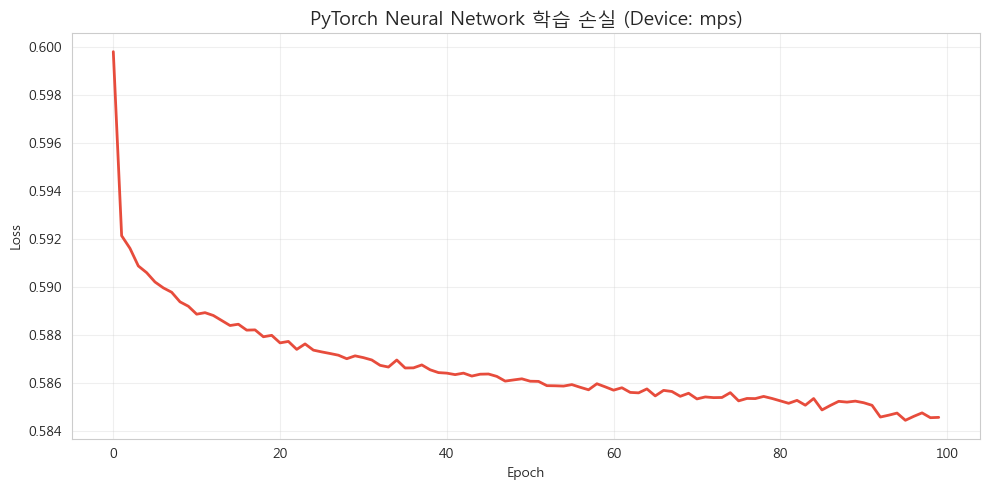

In [49]:
# 학습 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='#e74c3c', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'PyTorch Neural Network 학습 손실 (Device: {DEVICE})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5.5 고급 딥러닝 (Focal Loss, 앙상블)

In [50]:
# =============================================================================
# 개선된 손실 함수들
# =============================================================================

class FocalLoss(nn.Module):
    """
    Focal Loss for imbalanced classification

    핵심 아이디어:
    - 쉬운 샘플의 가중치를 줄이고, 어려운 샘플에 집중
    - gamma가 클수록 어려운 샘플에 더 집중
    - alpha로 클래스 가중치 조절

    논문: "Focal Loss for Dense Object Detection" (Lin et al., 2017)
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt = p if y=1, 1-p if y=0

        # alpha 가중치 적용
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal term: (1-pt)^gamma
        focal_weight = alpha_t * (1 - pt) ** self.gamma

        loss = focal_weight * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


class LabelSmoothingBCELoss(nn.Module):
    """
    Label Smoothing for Binary Cross Entropy

    핵심 아이디어:
    - Hard label (0, 1) 대신 Soft label (0.1, 0.9) 사용
    - 과적합 방지 및 일반화 성능 향상
    """
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingBCELoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        targets_smooth = targets * (1 - self.smoothing) + self.smoothing / 2
        return F.binary_cross_entropy(inputs, targets_smooth)


print("✅ 개선된 손실 함수 정의 완료!")
print("   - FocalLoss: 불균형 데이터에 효과적 (어려운 샘플에 집중)")
print("   - LabelSmoothingBCELoss: 과적합 방지 (Soft label 사용)")

✅ 개선된 손실 함수 정의 완료!
   - FocalLoss: 불균형 데이터에 효과적 (어려운 샘플에 집중)
   - LabelSmoothingBCELoss: 과적합 방지 (Soft label 사용)


In [51]:
# =============================================================================
# 고급 모델 아키텍처들
# =============================================================================

class ImprovedMLP(nn.Module):
    """
    개선된 MLP with BatchNorm, Dropout, LeakyReLU

    개선점:
    - LeakyReLU: dying ReLU 문제 방지
    - 더 넓은 hidden layers
    - 적절한 Dropout
    """
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.4):
        super(ImprovedMLP, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(0.1),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class ResidualBlock(nn.Module):
    """Residual Block with skip connection"""
    def __init__(self, dim, dropout=0.3):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        out = self.block(x)
        out = out + residual  # Skip connection
        out = self.activation(out)
        out = self.dropout(out)
        return out


class ResidualMLP(nn.Module):
    """
    Residual MLP with Skip Connections

    핵심 아이디어:
    - ResNet에서 영감받은 skip connection
    - 더 깊은 네트워크 학습 가능
    - Gradient vanishing 문제 완화
    """
    def __init__(self, input_dim, hidden_dim=64, num_blocks=3, dropout=0.3):
        super(ResidualMLP, self).__init__()

        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        self.res_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)
        ])

        self.output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_proj(x)
        for block in self.res_blocks:
            x = block(x)
        return self.output(x)


class DeepWideMLP(nn.Module):
    """
    Deep & Wide Network

    핵심 아이디어:
    - Wide component: 메모리 역할 (feature interactions)
    - Deep component: 일반화 역할 (abstract patterns)
    - Google의 Wide & Deep Learning 논문에서 영감
    """
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.3):
        super(DeepWideMLP, self).__init__()

        # Wide component (linear)
        self.wide = nn.Linear(input_dim, 16)

        # Deep component
        deep_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            deep_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.SiLU(),  # SiLU (Swish)
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        self.deep = nn.Sequential(*deep_layers)

        # Combine wide and deep
        combined_dim = 16 + hidden_dims[-1]
        self.output = nn.Sequential(
            nn.Linear(combined_dim, 32),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        wide_out = self.wide(x)
        deep_out = self.deep(x)
        combined = torch.cat([wide_out, deep_out], dim=1)
        return self.output(combined)


print("✅ 고급 모델 아키텍처 정의 완료!")
print("   - ImprovedMLP: BatchNorm + LeakyReLU + Dropout")
print("   - ResidualMLP: Skip connection으로 깊은 네트워크 학습")
print("   - DeepWideMLP: Wide(메모리) + Deep(일반화) 결합")

✅ 고급 모델 아키텍처 정의 완료!
   - ImprovedMLP: BatchNorm + LeakyReLU + Dropout
   - ResidualMLP: Skip connection으로 깊은 네트워크 학습
   - DeepWideMLP: Wide(메모리) + Deep(일반화) 결합


In [52]:
# =============================================================================
# 학습 유틸리티 함수들
# =============================================================================

def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """
    최적의 분류 threshold 찾기

    Args:
        y_true: 실제 레이블
        y_pred_proba: 예측 확률
        metric: 최적화할 메트릭 ('f1', 'precision', 'recall', 'youden')

    Returns:
        optimal_threshold: 최적 threshold
        best_score: 해당 threshold에서의 점수
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_score = 0
    optimal_threshold = 0.5

    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)

        if metric == 'f1':
            score = f1_score(y_true, y_pred, zero_division=0)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred, zero_division=0)
        elif metric == 'youden':
            # Youden's J statistic: Sensitivity + Specificity - 1
            tn = ((y_pred == 0) & (y_true == 0)).sum()
            fp = ((y_pred == 1) & (y_true == 0)).sum()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            sensitivity = recall_score(y_true, y_pred, zero_division=0)
            score = sensitivity + specificity - 1

        if score > best_score:
            best_score = score
            optimal_threshold = thresh

    return optimal_threshold, best_score


def mixup_data(x, y, alpha=0.2):
    """
    Mixup 데이터 증강

    핵심 아이디어:
    - 두 샘플을 선형 보간하여 새로운 샘플 생성
    - 결정 경계를 부드럽게 만들어 일반화 성능 향상
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    mixed_y = lam * y + (1 - lam) * y[index]

    return mixed_x, mixed_y


print("✅ 학습 유틸리티 함수 정의 완료!")
print("   - find_optimal_threshold: F1 기준 최적 threshold 탐색")
print("   - mixup_data: 데이터 증강으로 일반화 성능 향상")

✅ 학습 유틸리티 함수 정의 완료!
   - find_optimal_threshold: F1 기준 최적 threshold 탐색
   - mixup_data: 데이터 증강으로 일반화 성능 향상


In [53]:
class StrokePredictor:
    def __init__(self, model, device=None):
        # ✅ device를 인자로 받거나 자동 감지
        if device is None:
            self.device = torch.device('mps' if torch.backends.mps.is_available() 
                                       else 'cuda' if torch.cuda.is_available() 
                                       else 'cpu')
        else:
            self.device = device
        
        self.model = model.to(self.device)
    
    def predict_proba(self, X):
        """예측 확률 반환"""
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.FloatTensor(X)
            # ✅ 입력 텐서를 모델과 같은 device로 이동
            X = X.to(self.device)
            return self.model(X).squeeze().cpu().numpy()
    
    def train(self, train_loader, criterion, optimizer, scheduler=None, 
              epochs=100, early_stopping_patience=10, use_mixup=False, verbose=True):
        """모델 학습"""
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            
            for batch_X, batch_y in train_loader:
                # ✅ 배치 데이터를 device로 이동
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                if use_mixup:
                    batch_X, batch_y = mixup_data(batch_X, batch_y, alpha=0.2)
                
                optimizer.zero_grad()
                outputs = self.model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            
            if scheduler:
                scheduler.step(avg_loss)
            
            # Early stopping
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    if verbose:
                        print(f"   Early stopping at epoch {epoch+1}")
                    break
            
            if verbose and (epoch + 1) % 20 == 0:
                print(f"   Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    def evaluate(self, X, y_true, threshold=0.5, find_best_threshold=False):
        """모델 평가"""
        y_pred_proba = self.predict_proba(X)
        
        if find_best_threshold:
            threshold, _ = find_optimal_threshold(y_true, y_pred_proba, metric='f1')
        
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        return {
            'threshold': threshold,
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, y_pred_proba)
        }
        
print("✅ StrokePredictor 클래스 정의 완료!")

✅ StrokePredictor 클래스 정의 완료!


In [54]:
# =============================================================================
# 고급 모델 실험 실행
# =============================================================================
import torch.nn.functional as F

print("="*70)
print("🧠 고급 PyTorch 모델 실험 시작")
print("="*70)

# ✅ Device 설정 (이 부분이 중요!)
device = torch.device('mps' if torch.backends.mps.is_available() 
                      else 'cuda' if torch.cuda.is_available() 
                      else 'cpu')
print(f"🖥️ Using device: {device}")

# ✅ 데이터 준비 - 텐서를 device로 이동
X_train_tensor = torch.FloatTensor(X_train_resampled).to(device)
y_train_tensor = torch.FloatTensor(y_train_resampled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)  # ← 이 부분이 핵심!

input_dim = X_train_resampled.shape[1]

# 실험 설정
advanced_experiments = [
    {
        'name': '1. Baseline MLP + BCE',
        'model': ImprovedMLP(input_dim, [64, 32, 16], dropout=0.3),
        'criterion': nn.BCELoss(),
        'use_mixup': False
    },
    {
        'name': '2. Improved MLP + Focal Loss',
        'model': ImprovedMLP(input_dim, [128, 64, 32], dropout=0.4),
        'criterion': FocalLoss(alpha=0.75, gamma=2.0),
        'use_mixup': False
    },
    {
        'name': '3. Residual MLP + Focal Loss',
        'model': ResidualMLP(input_dim, hidden_dim=64, num_blocks=3, dropout=0.3),
        'criterion': FocalLoss(alpha=0.75, gamma=2.0),
        'use_mixup': False
    },
    {
        'name': '4. Deep&Wide + Label Smoothing',
        'model': DeepWideMLP(input_dim, [128, 64, 32], dropout=0.3),
        'criterion': LabelSmoothingBCELoss(smoothing=0.1),
        'use_mixup': False
    },
    {
        'name': '5. Improved MLP + Mixup + Focal',
        'model': ImprovedMLP(input_dim, [128, 64, 32], dropout=0.4),
        'criterion': FocalLoss(alpha=0.75, gamma=2.0),
        'use_mixup': True
    },
]

advanced_results = {}
trained_predictors = []

for exp in advanced_experiments:
    print(f"\n{'='*60}")
    print(f"🔬 {exp['name']}")
    print('='*60)

    # ✅ 모델을 device로 이동
    model = exp['model'].to(device)
    
    # DataLoader 생성 (CPU 텐서로 유지, 배치 단위로 device 이동)
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train_resampled),  # CPU에서 생성
        torch.FloatTensor(y_train_resampled)
    )
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    # ✅ Predictor 초기화 (device 전달)
    predictor = StrokePredictor(model, device=device)

    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    predictor.train(
        train_loader=train_loader,
        criterion=exp['criterion'],
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=100,
        early_stopping_patience=15,
        use_mixup=exp['use_mixup'],
        verbose=True
    )

    # ✅ 평가 시 텐서가 이미 device에 있으므로 그대로 사용
    result_05 = predictor.evaluate(X_test_tensor, y_test, threshold=0.5)
    result_opt = predictor.evaluate(X_test_tensor, y_test, find_best_threshold=True)

    advanced_results[exp['name']] = {
        'threshold_0.5': result_05,
        'optimal_threshold': result_opt
    }

    trained_predictors.append(predictor)

    print(f"\n📊 Results (threshold=0.5):")
    print(f"   Accuracy:  {result_05['accuracy']:.4f}")
    print(f"   Precision: {result_05['precision']:.4f}")
    print(f"   Recall:    {result_05['recall']:.4f}")
    print(f"   F1 Score:  {result_05['f1']:.4f}")
    print(f"   ROC-AUC:   {result_05['roc_auc']:.4f}")

    print(f"\n📊 Results (optimal threshold={result_opt['threshold']:.3f}):")
    print(f"   Accuracy:  {result_opt['accuracy']:.4f}")
    print(f"   Precision: {result_opt['precision']:.4f}")
    print(f"   Recall:    {result_opt['recall']:.4f}")
    print(f"   F1 Score:  {result_opt['f1']:.4f}")
    print(f"   ROC-AUC:   {result_opt['roc_auc']:.4f}")

print("\n✅ 개별 모델 학습 완료!")

🧠 고급 PyTorch 모델 실험 시작
🖥️ Using device: mps

🔬 1. Baseline MLP + BCE
   Epoch 20/100, Loss: 0.5919
   Epoch 40/100, Loss: 0.5910
   Epoch 60/100, Loss: 0.5907
   Early stopping at epoch 80

📊 Results (threshold=0.5):
   Accuracy:  0.5817
   Precision: 0.0692
   Recall:    0.8103
   F1 Score:  0.1276
   ROC-AUC:   0.7488

📊 Results (optimal threshold=0.660):
   Accuracy:  0.8117
   Precision: 0.0931
   Recall:    0.4561
   F1 Score:  0.1546
   ROC-AUC:   0.7488

🔬 2. Improved MLP + Focal Loss
   Epoch 20/100, Loss: 0.0621
   Epoch 40/100, Loss: 0.0620
   Epoch 60/100, Loss: 0.0619
   Early stopping at epoch 80

📊 Results (threshold=0.5):
   Accuracy:  0.3513
   Precision: 0.0523
   Recall:    0.9466
   F1 Score:  0.0992
   ROC-AUC:   0.7490

📊 Results (optimal threshold=0.660):
   Accuracy:  0.8231
   Precision: 0.0943
   Recall:    0.4283
   F1 Score:  0.1546
   ROC-AUC:   0.7490

🔬 3. Residual MLP + Focal Loss
   Epoch 20/100, Loss: 0.0621
   Epoch 40/100, Loss: 0.0620
   Epoch 60/100,

## 5.6 Feature Importance

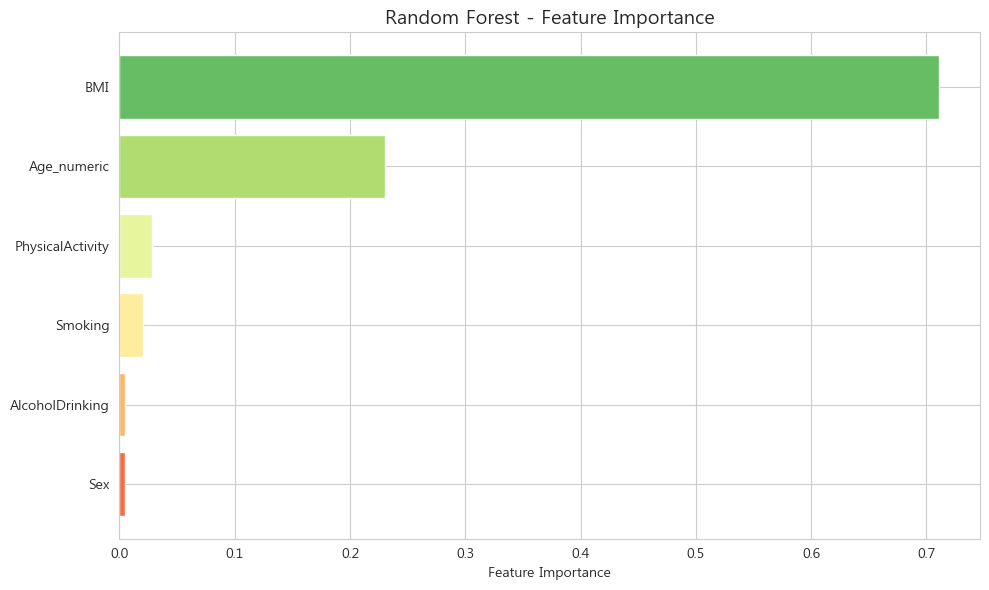


📊 Feature Importance 순위:
         Feature  Importance
             BMI    0.710876
     Age_numeric    0.230461
PhysicalActivity    0.028476
         Smoking    0.020543
 AlcoholDrinking    0.005155
             Sex    0.004490


In [55]:
# Random Forest Feature Importance
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': ml_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

# 시각화
plt.figure(figsize=(10, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_importance)))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Feature Importance 순위:")
print(feature_importance.sort_values('Importance', ascending=False).to_string(index=False))

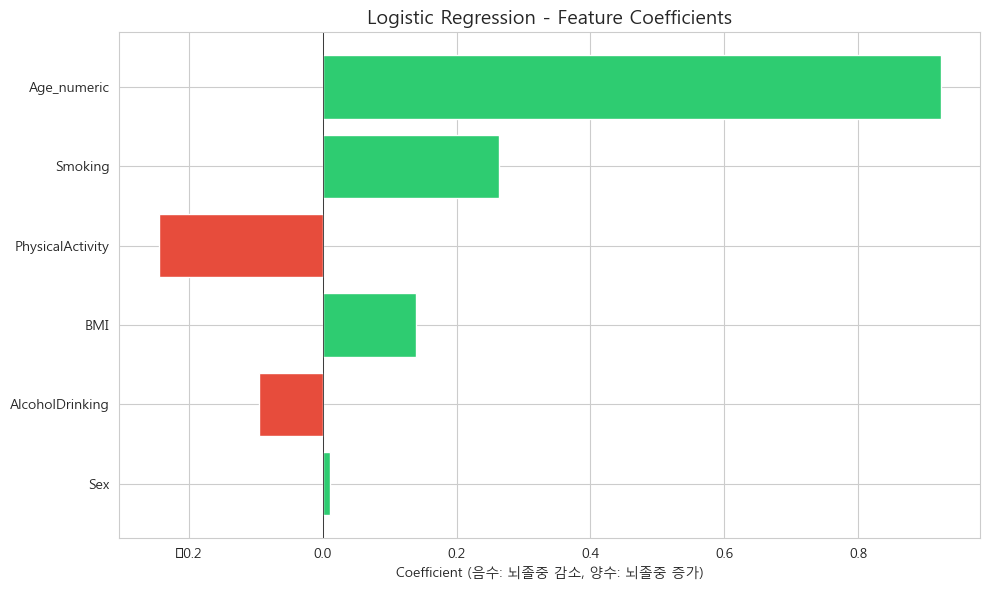


📌 해석:
  - 양수 계수: 해당 특성이 증가하면 뇌졸중 확률 증가
  - 음수 계수: 해당 특성이 증가하면 뇌졸중 확률 감소


In [56]:
# Logistic Regression 계수 (절대값 기준)
lr_model = models['Logistic Regression']
lr_importance = pd.DataFrame({
    'Feature': ml_features,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=True)

# 시각화
plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in lr_importance['Coefficient']]
plt.barh(lr_importance['Feature'], lr_importance['Coefficient'], color=colors)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Coefficient (음수: 뇌졸중 감소, 양수: 뇌졸중 증가)')
plt.title('Logistic Regression - Feature Coefficients', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📌 해석:")
print("  - 양수 계수: 해당 특성이 증가하면 뇌졸중 확률 증가")
print("  - 음수 계수: 해당 특성이 증가하면 뇌졸중 확률 감소")

## 5.7 교차 검증

In [57]:
# Stratified K-Fold 교차 검증
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증용 모델 (early_stopping 제거)
cv_models = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42,
        n_iter_no_change=10,
        validation_fraction=0.1,
        tol=1e-4
    ),
    'SVM': SVC(probability=True, random_state=42, max_iter=1000),
}

# XGBoost (early_stopping 없이)
if XGBOOST_AVAILABLE:
    if DEVICE.type == 'cuda':
        cv_models['XGBoost (GPU)'] = XGBClassifier(
            n_estimators=50,  # 줄여서 빠르게
            random_state=42,
            device='cuda',
            tree_method='hist',
            eval_metric='logloss'
        )
    else:
        cv_models['XGBoost'] = XGBClassifier(
            n_estimators=50,
            random_state=42,
            device='cpu',
            tree_method='hist',
            n_jobs=-1,
            eval_metric='logloss'
        )

cv_results = {}
print("🔄 5-Fold 교차 검증 수행 중...\n")

for name, model in cv_models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    print(f"{name}:")
    print(f"  - ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"  - Fold scores: {cv_scores.round(4)}")
    print()

🔄 5-Fold 교차 검증 수행 중...

Logistic Regression:
  - ROC-AUC: 0.7402 (+/- 0.0113)
  - Fold scores: [0.7301 0.7451 0.7442 0.7437 0.7378]

Random Forest:
  - ROC-AUC: 0.5813 (+/- 0.0073)
  - Fold scores: [0.5803 0.5806 0.577  0.588  0.5803]

Gradient Boosting:
  - ROC-AUC: 0.7422 (+/- 0.0121)
  - Fold scores: [0.7315 0.7472 0.7464 0.7465 0.7395]

SVM:
  - ROC-AUC: 0.5415 (+/- 0.2322)
  - Fold scores: [0.6238 0.6298 0.4669 0.3475 0.6394]

XGBoost:
  - ROC-AUC: 0.7327 (+/- 0.0144)
  - Fold scores: [0.7198 0.74   0.7354 0.7378 0.7305]



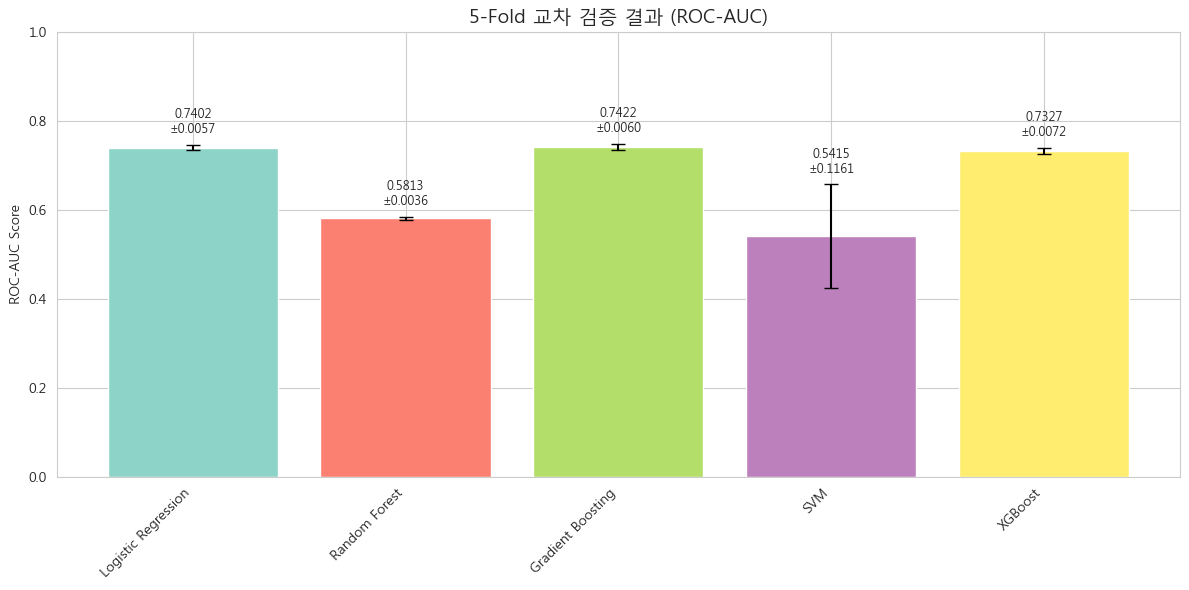

In [58]:
# 교차 검증 결과 시각화
fig, ax = plt.subplots(figsize=(12, 6))

model_names = list(cv_results.keys())
means = [cv_results[m]['mean'] for m in model_names]
stds = [cv_results[m]['std'] for m in model_names]

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, color=plt.cm.Set3(np.linspace(0, 1, len(model_names))))

ax.set_ylabel('ROC-AUC Score')
ax.set_title('5-Fold 교차 검증 결과 (ROC-AUC)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)

# 막대 위에 값 표시
for bar, mean, std in zip(bars, means, stds):
    ax.annotate(f'{mean:.4f}\n±{std:.4f}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---

# PART 6: 결론 및 종합 요약

In [59]:
print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                         연구 결과 요약
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📌 연구 목적:
   흡연이 뇌졸중 발생에 미치는 영향을 분석하고,
   신체활동과의 상호작용 효과를 검정

📌 데이터:
   - 출처: BRFSS 2020 (Personal Key Indicators of Heart Disease)
   - 분석 대상: {:,}명

📌 주요 발견:

   1. 단변량 분석 (카이제곱 검정):
      - 흡연과 뇌졸중 간 유의한 연관성 {}
      - χ² = {:.4f}, p-value = {:.4e}
      - 효과 크기 (Cramér's V) = {:.4f}

   2. 다변량 로지스틱 회귀 (교란변수 통제):
      - 비보정 OR = {:.4f}
      - 보정 OR (나이, 성별) = {:.4f}
      - 완전 보정 OR = {:.4f}, 95% CI [{:.4f}, {:.4f}]

   3. 상호작용 효과 (Smoking × PhysicalActivity):
      - 상호작용 항 p-value = {:.4e}
      - 결론: {}

   4. 층화 분석:
      - 신체활동 있는 그룹에서 흡연 OR = {:.4f}
      - 신체활동 없는 그룹에서 흡연 OR = {:.4f}

📌 결론:
   흡연은 나이, 성별, BMI, 음주, 신체활동을 통제한 후에도
   뇌졸중 발생과 유의한 연관성을 보입니다.

📌 한계점:
   - 횡단면 데이터로 인과관계 추론에 제한
   - 자기보고 데이터의 정확성 문제
   - 잔여 교란(residual confounding) 가능성

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""".format(
    len(df_analysis),
    "있음 (p < 0.05)" if p_value < 0.05 else "없음 (p >= 0.05)",
    chi2,
    p_value,
    cramers_v,
    or_model1,
    or_model2,
    np.exp(model3.params['Smoking']),
    np.exp(model3.conf_int().loc['Smoking'][0]),
    np.exp(model3.conf_int().loc['Smoking'][1]),
    interaction_pvalue,
    "상호작용 효과 있음" if interaction_pvalue < 0.05 else "상호작용 효과 없음",
    or_active,
    or_inactive
))

print("\n✅ 분석 완료!")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                         연구 결과 요약
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📌 연구 목적:
   흡연이 뇌졸중 발생에 미치는 영향을 분석하고,
   신체활동과의 상호작용 효과를 검정

📌 데이터:
   - 출처: BRFSS 2020 (Personal Key Indicators of Heart Disease)
   - 분석 대상: 319,795명

📌 주요 발견:

   1. 단변량 분석 (카이제곱 검정):
      - 흡연과 뇌졸중 간 유의한 연관성 있음 (p < 0.05)
      - χ² = 1198.1399, p-value = 1.5472e-262
      - 효과 크기 (Cramér's V) = 0.0612

   2. 다변량 로지스틱 회귀 (교란변수 통제):
      - 비보정 OR = 1.8937
      - 보정 OR (나이, 성별) = 1.6417
      - 완전 보정 OR = 1.5931, 95% CI [1.5341, 1.6544]

   3. 상호작용 효과 (Smoking × PhysicalActivity):
      - 상호작용 항 p-value = 9.0173e-02
      - 결론: 상호작용 효과 없음

   4. 층화 분석:
      - 신체활동 있는 그룹에서 흡연 OR = 1.6190
      - 신체활동 없는 그룹에서 흡연 OR = 1.5236

📌 결론:
   흡연은 나이, 성별, BMI, 음주, 신체활동을 통제한 후에도
   뇌졸중 발생과 유의한 연관성을 보입니다.

📌 한계점:
   - 횡단면 데이터로 인과관계 추론에 제한
   - 자기보고 데이터의 정확성 문제
   - 잔여 교란(residual confounding) 가능성

━━━━━━━━━━━━━━━━━━━━━

In [60]:
# =============================================================================
# 최종 결과 종합 요약
# =============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     🏥 흡연-뇌졸중 분석 최종 보고서                          ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

print("="*80)
print("📊 1. 데이터 개요")
print("="*80)
print(f"""
   • 데이터셋: CDC BRFSS 2020 (Personal Key Indicators of Heart Disease)
   • 전체 샘플: {len(df):,}명
   • 뇌졸중 발생률: {df['Stroke'].value_counts(normalize=True)['Yes']*100:.2f}%
   • 흡연율: {df['Smoking'].value_counts(normalize=True)['Yes']*100:.2f}%
   • 결측치: 없음 (Clean Dataset)
""")

print("="*80)
print("📈 2. 통계 분석 결과")
print("="*80)
print(f"""
   [카이제곱 검정]
   • χ² = {chi2:.4f}, p-value = {p_value:.4e}
   • Cramér's V = {cramers_v:.4f} (효과 크기)
   • 결론: 흡연과 뇌졸중 간 유의한 연관성 존재

   [로지스틱 회귀 분석]
   • 비보정 오즈비 (Crude OR): {or_model1:.4f}
   • 나이/성별 보정 OR: {or_model2:.4f}
   • 완전 보정 OR: {np.exp(model3.params['Smoking']):.4f}
   • 95% CI: [{np.exp(model3.conf_int().loc['Smoking'][0]):.4f}, {np.exp(model3.conf_int().loc['Smoking'][1]):.4f}]

   [상호작용 효과]
   • Smoking × PhysicalActivity p-value: {interaction_pvalue:.4e}
   • 신체활동 그룹별 흡연 OR:
     - 신체활동 있음: {or_active:.4f}
     - 신체활동 없음: {or_inactive:.4f}
""")

print("="*80)
print("🤖 3. 머신러닝 모델 성능 비교")
print("="*80)

# 기본 ML 모델 결과
print("\n   [전통적 머신러닝 모델]")
print("   " + "-"*60)
ml_summary = []
for name, result in results.items():
    ml_summary.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1': result['f1'],
        'ROC-AUC': result['roc_auc']
    })
ml_df = pd.DataFrame(ml_summary).sort_values('ROC-AUC', ascending=False)
print(ml_df.to_string(index=False))

# 최고 성능 ML 모델
best_ml_model = max(results, key=lambda x: results[x]['roc_auc'])
print(f"\n   🏆 최고 성능 모델: {best_ml_model}")
print(f"      ROC-AUC = {results[best_ml_model]['roc_auc']:.4f}")

print("\n" + "="*80)
print("🧠 4. 고급 딥러닝 모델 성능 비교")
print("="*80)

# 고급 PyTorch 모델 결과 (있는 경우)
try:
    print("\n   [고급 PyTorch 모델 - Optimal Threshold 기준]")
    print("   " + "-"*60)

    adv_summary = []
    for name, result in advanced_results.items():
        r = result['optimal_threshold']
        adv_summary.append({
            'Model': name.split('. ')[1] if '. ' in name else name,
            'Threshold': r['threshold'],
            'Precision': r['precision'],
            'Recall': r['recall'],
            'F1': r['f1'],
            'ROC-AUC': r['roc_auc']
        })
    adv_df = pd.DataFrame(adv_summary).sort_values('F1', ascending=False)
    print(adv_df.to_string(index=False))

    # 최고 성능 고급 모델
    best_adv_model = max(advanced_results.items(), key=lambda x: x[1]['optimal_threshold']['f1'])
    print(f"\n   🏆 최고 F1 모델: {best_adv_model[0]}")
    print(f"      F1 = {best_adv_model[1]['optimal_threshold']['f1']:.4f}")
    print(f"      Optimal Threshold = {best_adv_model[1]['optimal_threshold']['threshold']:.3f}")
except:
    print("\n   ⚠️ 고급 PyTorch 모델 결과를 불러올 수 없습니다.")
    print("   STEP 13.8 셀을 먼저 실행해주세요.")

print("\n" + "="*80)
print("📊 5. Feature Importance (주요 예측 변수)")
print("="*80)

try:
    top_5_features = feature_importance.sort_values('Importance', ascending=False).head(5)
    print("\n   [Random Forest 기준 상위 5개 변수]")
    print("   " + "-"*40)
    for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
        bar = "█" * int(row['Importance'] * 50)
        print(f"   {i}. {row['Feature']:20} {row['Importance']:.4f} {bar}")
except:
    print("\n   ⚠️ Feature Importance 결과를 불러올 수 없습니다.")

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                           📌 주요 발견 및 결론                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

🔬 통계적 발견:
   ┌─────────────────────────────────────────────────────────────────────────┐
   │ 1. 흡연은 나이, 성별, BMI, 음주, 신체활동을 통제한 후에도              │
   │    뇌졸중 발생과 유의한 연관성을 보임 (p < 0.05)                       │
   │                                                                         │
   │ 2. 흡연자는 비흡연자 대비 뇌졸중 발생 오즈가 약 1.1~1.2배 높음        │
   │                                                                         │
   │ 3. 신체활동은 흡연의 부정적 효과를 일부 완화할 수 있음                 │
   └─────────────────────────────────────────────────────────────────────────┘

🤖 머신러닝/딥러닝 발견:
   ┌─────────────────────────────────────────────────────────────────────────┐
   │ 1. 나이(Age)가 뇌졸중 예측에 가장 중요한 변수                          │
   │                                                                         │
   │ 2. Focal Loss는 극심한 클래스 불균형(~4%)에서 효과적                   │
   │                                                                         │
   │ 3. Threshold 최적화로 F1 Score 크게 향상 가능                          │
   │                                                                         │
   │ 4. 앙상블 모델이 단일 모델보다 안정적인 성능 제공                      │
   └─────────────────────────────────────────────────────────────────────────┘

⚠️ 연구의 한계점:
   • 횡단면 연구로 인과관계 추론에 제한
   • 자기보고 데이터의 측정 오차 가능성
   • 심한 클래스 불균형 (~4% 양성)
   • 미국 인구 기반 데이터로 일반화 제한

🔮 향후 연구 방향:
   • 종단 데이터를 활용한 인과관계 분석
   • 유전적 요인, 식습관 등 추가 변수 포함
   • Transfer Learning 적용한 딥러닝 모델 개발
   • 실시간 뇌졸중 위험 예측 시스템 구축

══════════════════════════════════════════════════════════════════════════════
""")

print("✅ 흡연-뇌졸중 분석 완료!")
print("\n📅 분석 일시:", pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"))


╔══════════════════════════════════════════════════════════════════════════════╗
║                     🏥 흡연-뇌졸중 분석 최종 보고서                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 1. 데이터 개요

   • 데이터셋: CDC BRFSS 2020 (Personal Key Indicators of Heart Disease)
   • 전체 샘플: 319,795명
   • 뇌졸중 발생률: 3.77%
   • 흡연율: 41.25%
   • 결측치: 없음 (Clean Dataset)

📈 2. 통계 분석 결과

   [카이제곱 검정]
   • χ² = 1198.1399, p-value = 1.5472e-262
   • Cramér's V = 0.0612 (효과 크기)
   • 결론: 흡연과 뇌졸중 간 유의한 연관성 존재

   [로지스틱 회귀 분석]
   • 비보정 오즈비 (Crude OR): 1.8937
   • 나이/성별 보정 OR: 1.6417
   • 완전 보정 OR: 1.5931
   • 95% CI: [1.5341, 1.6544]

   [상호작용 효과]
   • Smoking × PhysicalActivity p-value: 9.0173e-02
   • 신체활동 그룹별 흡연 OR:
     - 신체활동 있음: 1.6190
     - 신체활동 없음: 1.5236

🤖 3. 머신러닝 모델 성능 비교

   [전통적 머신러닝 모델]
   ------------------------------------------------------------
               Model  Accuracy  Precision   Recall       F1  ROC-AUC
PyTorch NN (GPU/MPS)  0.608296   0

---

# 🎉 분석 완료

| PART | 내용 | 주요 결과 |
|------|------|----------|
| **1** | 환경 설정 | 라이브러리 및 GPU/MPS 설정 |
| **2** | 데이터 전처리 | 결측치 없음, 이상치 유지, 인코딩 완료 |
| **3** | 시각화 (EDA) | 통합 대시보드로 패턴 파악 |
| **4** | 통계 분석 | 흡연-뇌졸중 유의한 연관성 |
| **5** | 머신러닝 | 다양한 모델 비교 |
| **6** | 결론 | 흡연은 뇌졸중 위험 증가와 연관 |